# Imports

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# The MSN02 Dataset

In [119]:
msn02 = pd.read_csv("data/msn_02_fuel_leak_signals_preprocessed.csv", delimiter=';')

In [120]:
# Setting index as datetime
msn02['UTC_TIME'] = pd.to_datetime(msn02['UTC_TIME'])
msn02 = msn02.set_index("UTC_TIME")

msn02 = msn02.sort_index()

In [121]:
# Dropping Duplicates
msn02 = msn02.drop_duplicates()

In [122]:
# Keeping only relevant columns

# Same as those available in the other MSNs except for added VALUE_FUEL_QTYCCx
columns = ['MSN', 
           'Flight',
           'FLIGHT_PHASE_COUNT','FUEL_USED_1','FUEL_USED_2', 'FUEL_USED_3', 'FUEL_USED_4', 
           'FW_GEO_ALTITUDE',
           'VALUE_FOB', 
           #'VALUE_FUEL_QTY_CC1', 'VALUE_FUEL_QTY_CC2', 'VALUE_FUEL_QTY_CC3', 'VALUE_FUEL_QTY_CC4', 
           'VALUE_FUEL_QTY_CT', 
           'VALUE_FUEL_QTY_FT1', 'VALUE_FUEL_QTY_FT2', 'VALUE_FUEL_QTY_FT3', 'VALUE_FUEL_QTY_FT4', 
           'VALUE_FUEL_QTY_LXT', 'VALUE_FUEL_QTY_RXT',
           'LEAK_DETECTION_LEAK_FLOW', 'STATUS_FUEL_LEAK_DETECTED_VALID'
           ]

df = msn02[columns]

In [123]:
# Dropping all rows with nulls
df = df.dropna(subset=columns)

In [124]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503467 entries, 2010-10-26 12:56:15 to 2017-01-23 20:28:33
Data columns (total 18 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   MSN                              503467 non-null  object 
 1   Flight                           503467 non-null  object 
 2   FLIGHT_PHASE_COUNT               503467 non-null  float64
 3   FUEL_USED_1                      503467 non-null  float64
 4   FUEL_USED_2                      503467 non-null  float64
 5   FUEL_USED_3                      503467 non-null  float64
 6   FUEL_USED_4                      503467 non-null  float64
 7   FW_GEO_ALTITUDE                  503467 non-null  float64
 8   VALUE_FOB                        503467 non-null  float64
 9   VALUE_FUEL_QTY_CT                503467 non-null  float64
 10  VALUE_FUEL_QTY_FT1               503467 non-null  float64
 11  VALUE_FUEL_QTY_FT2             

### Identifying Unique Flight Instances

In [125]:
# Identify Different Flights within the same flight number
# ========================================================

# Identify when a new flight starts (FLIGHT_PHASE_COUNT resets within each Flight)
df['NEW_FLIGHT'] = df.groupby('Flight')['FLIGHT_PHASE_COUNT'].diff().lt(0)

# Assign a unique flight instance number per Flight
df['FLIGHT_INSTANCE'] = df.groupby('Flight')['NEW_FLIGHT'].cumsum()

# New column to identify unique flights
df['FLIGHT_ID'] = df['Flight'].astype(str) + "_" + df['FLIGHT_INSTANCE'].astype(str)

In [126]:
# Assuming df is your DataFrame and the index is already a DatetimeIndex
flight_durations = df.groupby('FLIGHT_ID').apply(lambda x: x.index.max() - x.index.min())

# Calculate the average duration across all flights
average_duration = flight_durations.mean()

print(average_duration)

0 days 01:03:50.014705882


### `STATUS_FUEL_LEAK_DETECTED`

In [127]:
status_counts = df['STATUS_FUEL_LEAK_DETECTED_VALID'].value_counts()
status_counts

STATUS_FUEL_LEAK_DETECTED_VALID
1.0    503384
0.0        83
Name: count, dtype: int64

Values of 0 in `STATUS_FUEL_LEAK_DETECTED_VALID` indiciate that the leak detection logic is not enabled. Therefore, we will filter out these values in our dataset

In [128]:
df = df[df["STATUS_FUEL_LEAK_DETECTED_VALID"]==1]

We will be utilizing the intial fuel on board value for feature engineering below. However, this needs to be calcuated before we filter out the flight phases.

In [129]:
# This will be used later
# Find the initial fuel value for each flight instance
df['START_FOB'] = df.groupby('FLIGHT_ID')['VALUE_FOB'].transform('first')

Additionally, we will only take into account the the cruise phase of the flight, or where `FLIGHT_PHASE_COUNT` is 8

In [130]:
# Filter out only fro flight phase 8 - Cruise
df = df[df["FLIGHT_PHASE_COUNT"]==8.0]

In [131]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 383551 entries, 2010-10-26 13:32:07 to 2017-01-23 20:17:48
Data columns (total 22 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   MSN                              383551 non-null  object 
 1   Flight                           383551 non-null  object 
 2   FLIGHT_PHASE_COUNT               383551 non-null  float64
 3   FUEL_USED_1                      383551 non-null  float64
 4   FUEL_USED_2                      383551 non-null  float64
 5   FUEL_USED_3                      383551 non-null  float64
 6   FUEL_USED_4                      383551 non-null  float64
 7   FW_GEO_ALTITUDE                  383551 non-null  float64
 8   VALUE_FOB                        383551 non-null  float64
 9   VALUE_FUEL_QTY_CT                383551 non-null  float64
 10  VALUE_FUEL_QTY_FT1               383551 non-null  float64
 11  VALUE_FUEL_QTY_FT2             

# The Target Variable

### `LEAK_FLOW_FLAG`
This variable was engineered from setting a threshold for `LEAK_DETECTION_LEAK_FLOW`. If the `LEAK_DETECTION_LEAK_FLOW` value is greater than the threshold, the `LEAK_FLOW_FLAG` is set to 1, meaning that there is a leak

In [132]:
df['LEAK_DETECTION_LEAK_FLOW'].describe()

count    383551.000000
mean        -86.149972
std        2362.408800
min      -65228.100000
25%        -166.903600
50%           0.000000
75%         157.766250
max       57384.170000
Name: LEAK_DETECTION_LEAK_FLOW, dtype: float64

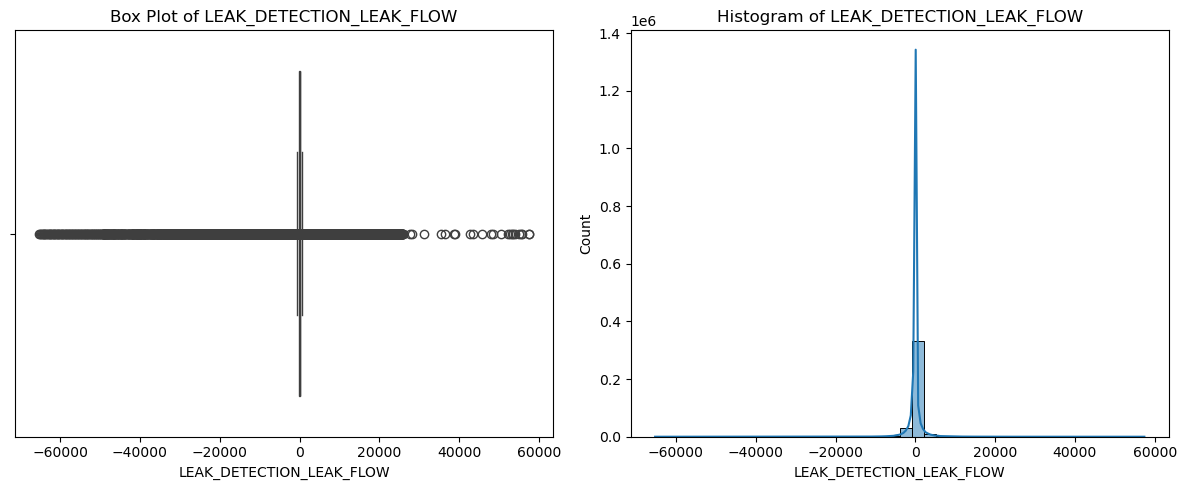

In [133]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot
sns.boxplot(x=df['LEAK_DETECTION_LEAK_FLOW'], ax=axes[0])
axes[0].set_title('Box Plot of LEAK_DETECTION_LEAK_FLOW')

# Histogram
sns.histplot(df["LEAK_DETECTION_LEAK_FLOW"], bins=40, kde=True, ax=axes[1])
axes[1].set_title('Histogram of LEAK_DETECTION_LEAK_FLOW')

plt.tight_layout()
plt.show()

We can see that there are negative values in `LEAK_DETECTION_LEAK_FLOW`. Thus, the negative values could indicate that there is less fuel usage than expected, possibly due to aspects such as internal tank transfers or sensor errors. In any case, the negative values here signify that there is not a leak. As such, those will be removed.|

In [134]:
df = df[df["LEAK_DETECTION_LEAK_FLOW"] >= 0]

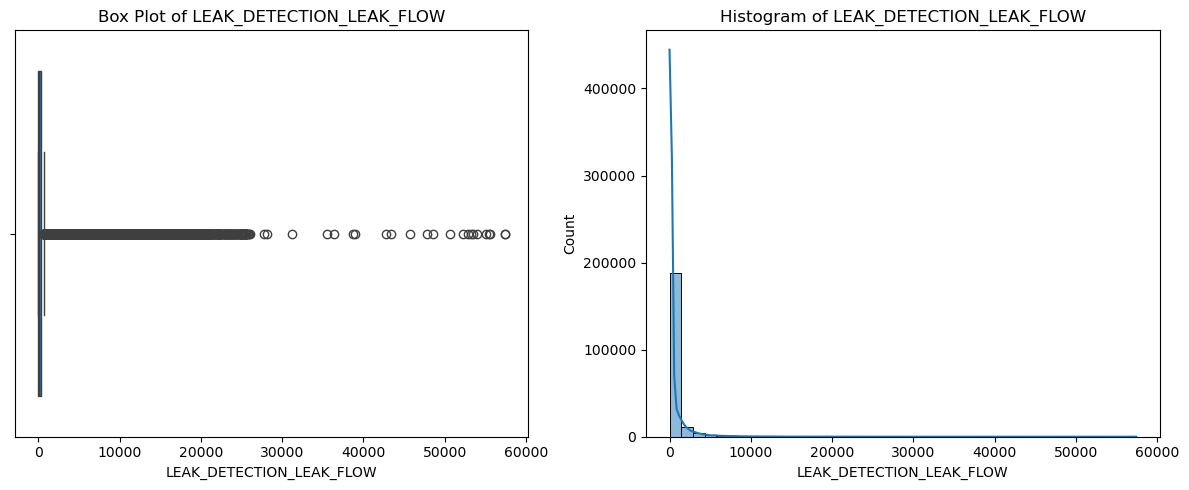

In [135]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot
sns.boxplot(x=df['LEAK_DETECTION_LEAK_FLOW'], ax=axes[0])
axes[0].set_title('Box Plot of LEAK_DETECTION_LEAK_FLOW')

# Histogram
sns.histplot(df["LEAK_DETECTION_LEAK_FLOW"], bins=40, kde=True, ax=axes[1])
axes[1].set_title('Histogram of LEAK_DETECTION_LEAK_FLOW')

plt.tight_layout()
plt.show()

#### *Setting a threshold*
Like mentioned in the meeting with *Airbus* a threshold of 2,500 will be used

In [136]:
threshold = 2500

In [137]:
df['LEAK_FLOW_FLAG'] = (df['LEAK_DETECTION_LEAK_FLOW'] > threshold).astype(int)

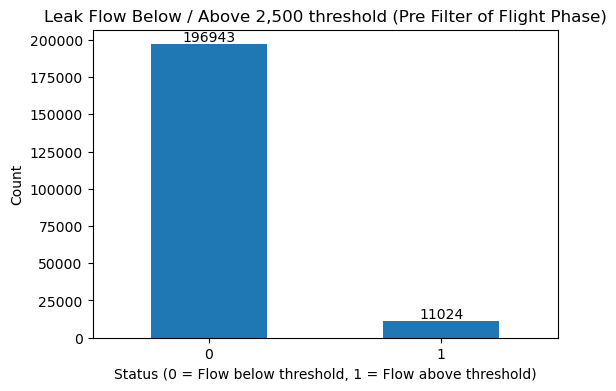

In [138]:
status_counts = df['LEAK_FLOW_FLAG'].value_counts()

plt.figure(figsize=(6, 4))
bars = status_counts.plot(kind='bar')

plt.title('Leak Flow Below / Above 2,500 threshold (Pre Filter of Flight Phase)')
plt.xlabel('Status (0 = Flow below threshold, 1 = Flow above threshold)')
plt.ylabel('Count')
plt.xticks(rotation=0)

for i, value in enumerate(status_counts):
    plt.text(i, value + 0.1, str(value), ha='center', va='bottom')

plt.show()


In [139]:
df.loc[df['LEAK_FLOW_FLAG'] == 1, 'FLIGHT_ID'].unique()

array(['V0094_0', 'V0095_0', 'V0098_0', 'V0099_0', 'V0132_0', 'V0133_1',
       'V0134_0', 'V0135_1', 'V0136_0', 'V0137_1', 'V0138_1', 'V0138_2',
       'V0138_4', 'V0138_5', 'V0138_6', 'V0138_7', 'V0138_10', 'V0138_11',
       'V0138_12', 'V0140_0', 'V0344_0', 'V0345_0', 'V0345_1', 'V0345_2',
       'V0345_3', 'V0345_4', 'V0345_6', 'V0345_7', 'V0345_8', 'V0346_0',
       'V0346_2', 'V0346_6', 'V0346_10', 'V0347_1', 'V0348_0'],
      dtype=object)

# Feature Engineering

### Fuel Discrepancy

In [140]:
# Calculating Fuel Discrepancy
# ============================

# Sort by time
df = df.sort_index()

# Calculate the total fuel used
df['TOTAL_FUEL_USED'] = df['FUEL_USED_1'] + df['FUEL_USED_2'] + df['FUEL_USED_3'] + df['FUEL_USED_4']

# Calcuate expected fuel on board
df['EXPECTED_FOB'] = df['START_FOB'] - df['TOTAL_FUEL_USED']

# Find Fuel Discrepancy between expected value and current value
df["FOB_DIFFERENCE"] = (df['EXPECTED_FOB'] - df['VALUE_FOB']).abs()

### Fuel Leak Rate

In [141]:
# Calculate the fuel leak rate

# Change in Fuel on Board (Actual)
df['FOB_CHANGE'] = df['VALUE_FOB'].diff()

# Expected Change based on fuel burned (negative because fuel is consumed)
df['EXPECTED_FOB_CHANGE'] = -df['TOTAL_FUEL_USED'].diff()  

# Fuel Leak Rate (If positive, actual fuel loss exceeds expected)
df['FUEL_LEAK_RATE'] = df['EXPECTED_FOB_CHANGE'] - df['FOB_CHANGE']

# Handle first row NaN values after diff()
df['FOB_CHANGE'] = df['FOB_CHANGE'].fillna(0)
df['EXPECTED_FOB_CHANGE'] = df['EXPECTED_FOB_CHANGE'].fillna(0)
df['FUEL_LEAK_RATE'] = df['FUEL_LEAK_RATE'].fillna(0)


### Left Wing, Right Wing Discrepancy

In [142]:
# Total Fuel in Left and Right Wing
df['TOTAL_FUEL_LW'] = (df['VALUE_FUEL_QTY_LXT'] + df['VALUE_FUEL_QTY_FT1'] + df['VALUE_FUEL_QTY_FT2'])
df['TOTAL_FUEL_RW'] = (df['VALUE_FUEL_QTY_RXT'] + df['VALUE_FUEL_QTY_FT3'] + df['VALUE_FUEL_QTY_FT4'])

# Fuel Difference
df['LW_RW_DIFF'] = (df['TOTAL_FUEL_LW'] - df['TOTAL_FUEL_RW']).abs()

### Discrepancy between given `VALUE_FOB` and our own calcuations of fuel on board `FUEL_IN_TANKS`

In [143]:
# Total amount of fuel in tanks
df['FUEL_IN_TANKS'] = df['VALUE_FUEL_QTY_CT'] + df['VALUE_FUEL_QTY_FT1'] + df['VALUE_FUEL_QTY_FT2'] + df['VALUE_FUEL_QTY_FT3'] + df['VALUE_FUEL_QTY_FT4'] + df['VALUE_FUEL_QTY_LXT'] + df['VALUE_FUEL_QTY_RXT']

# Difference between our calcuations and given calculations
df['CALC_VALUE_FOB_DIFF'] =  df['FUEL_IN_TANKS'] - df['VALUE_FOB']

### Assumption: Intiial FOB should equate to the sum of the current Fuel on Board + Total Fuel Used

In [144]:
df['START_FOB_VS_FOB_FUELUSED'] = df['START_FOB'] - (df['FUEL_IN_TANKS'] + df['TOTAL_FUEL_USED'])

### Altitude Difference

In [145]:
df['ALTITUDE_DIFF'] = df['FW_GEO_ALTITUDE'].diff().fillna(0)     

# Exploratory Data Analysis (EDA)

In [146]:
# Flights with Leaks
df.loc[df['LEAK_FLOW_FLAG'] == 1, 'FLIGHT_ID'].unique()

array(['V0094_0', 'V0095_0', 'V0098_0', 'V0099_0', 'V0132_0', 'V0133_1',
       'V0134_0', 'V0135_1', 'V0136_0', 'V0137_1', 'V0138_1', 'V0138_2',
       'V0138_4', 'V0138_5', 'V0138_6', 'V0138_7', 'V0138_10', 'V0138_11',
       'V0138_12', 'V0140_0', 'V0344_0', 'V0345_0', 'V0345_1', 'V0345_2',
       'V0345_3', 'V0345_4', 'V0345_6', 'V0345_7', 'V0345_8', 'V0346_0',
       'V0346_2', 'V0346_6', 'V0346_10', 'V0347_1', 'V0348_0'],
      dtype=object)

## *With Given Features*

### `FW_GEO_ALTITUDE`

In [147]:
df['FW_GEO_ALTITUDE'].describe()

count    207967.000000
mean      14540.130710
std       10159.597477
min        -372.102700
25%        5105.199500
50%       11792.500000
75%       20678.475000
max       36496.800000
Name: FW_GEO_ALTITUDE, dtype: float64

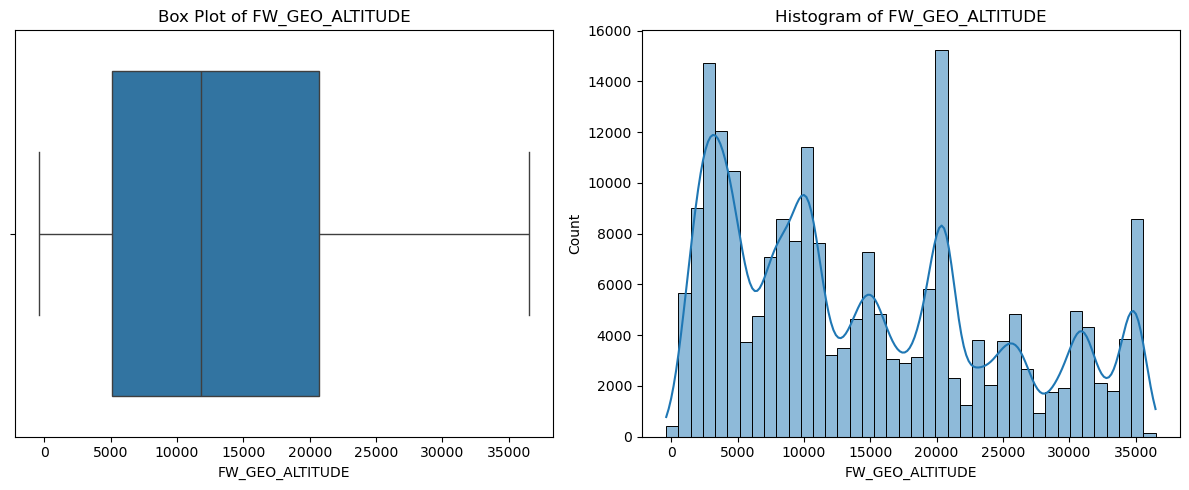

In [148]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot
sns.boxplot(x=df['FW_GEO_ALTITUDE'], ax=axes[0])
axes[0].set_title('Box Plot of FW_GEO_ALTITUDE')

# Histogram
sns.histplot(df["FW_GEO_ALTITUDE"], bins=40, kde=True, ax=axes[1])
axes[1].set_title('Histogram of FW_GEO_ALTITUDE')

plt.tight_layout()
plt.show()

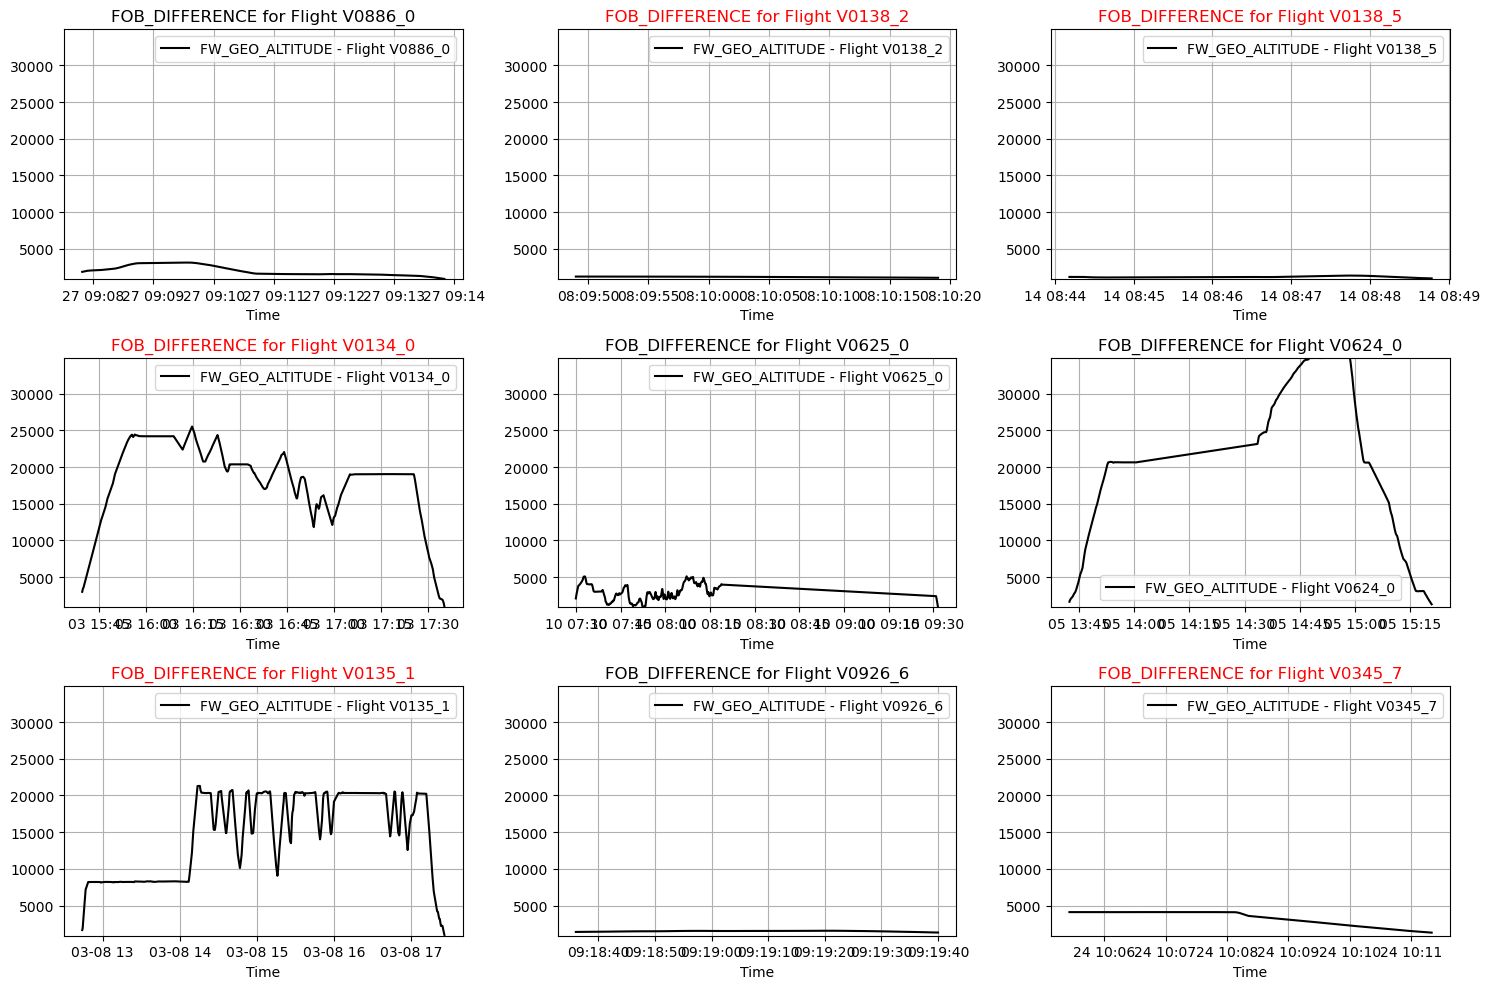

In [149]:
# Plotting FW_GEO_ALTITUDE in Unique Fights
# =======================================
np.random.seed(12)  # Set a seed for reproducibility
flights_to_plot = np.random.choice(df['FLIGHT_ID'].unique(), size=9, replace=False)

rows = 3
cols = 3

y_min = df[df['FLIGHT_ID'].isin(flights_to_plot)]['FW_GEO_ALTITUDE'].min()
y_max = df[df['FLIGHT_ID'].isin(flights_to_plot)]['FW_GEO_ALTITUDE'].max()

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

# Unique flights with leaks
leak_flights = set(df.loc[df['LEAK_FLOW_FLAG'] == 1, 'FLIGHT_ID'].unique())

for idx, flight in enumerate(flights_to_plot):
    if idx >= len(axes):  # Avoid indexing error if there are more flights than subplot slots
        break
    
    flight_data = df[df['FLIGHT_ID'] == flight]
    
    ax = axes[idx]
    
    # Set title color to red if the flight has a leak, otherwise black
    title_color = 'red' if flight in leak_flights else 'black'
    
    ax.plot(flight_data.index, flight_data['FW_GEO_ALTITUDE'], label=f'FW_GEO_ALTITUDE - Flight {flight}', color='black')

    ax.legend()
    ax.set_title(f'FOB_DIFFERENCE for Flight {flight}', color=title_color)
    ax.set_xlabel('Time')
    ax.set_ylim(y_min, y_max)
    ax.grid(True)

plt.tight_layout()
plt.show()


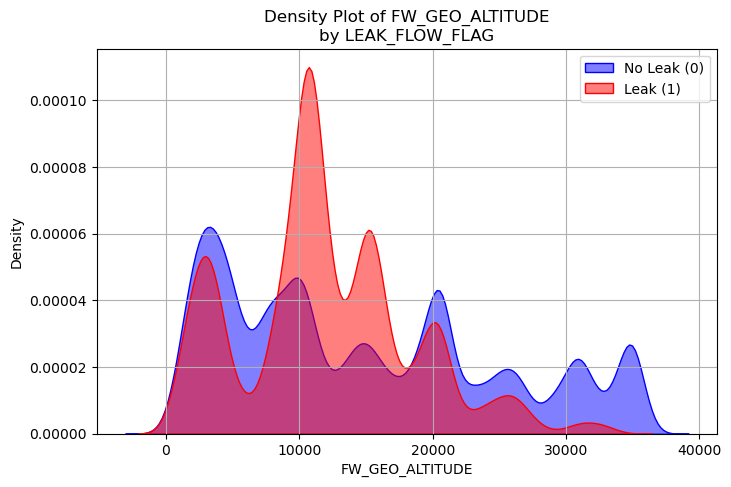

In [150]:
plt.figure(figsize=(8, 5))

sns.kdeplot(df[df['LEAK_FLOW_FLAG'] == 0]['FW_GEO_ALTITUDE'], 
            label="No Leak (0)", fill=True, alpha=0.5, color='blue')

sns.kdeplot(df[df['LEAK_FLOW_FLAG'] == 1]['FW_GEO_ALTITUDE'], 
            label="Leak (1)", fill=True, alpha=0.5, color='red')

plt.xlabel("FW_GEO_ALTITUDE")
plt.ylabel("Density")
plt.title("Density Plot of FW_GEO_ALTITUDE\nby LEAK_FLOW_FLAG")
plt.legend()
plt.grid(True)

plt.show()

### `VALUE_FOB`

In [151]:
df['VALUE_FOB'].describe()

count    207967.000000
mean      17653.502657
std        7486.771325
min        4493.000000
25%       11259.000000
50%       16913.000000
75%       23521.500000
max       39504.000000
Name: VALUE_FOB, dtype: float64

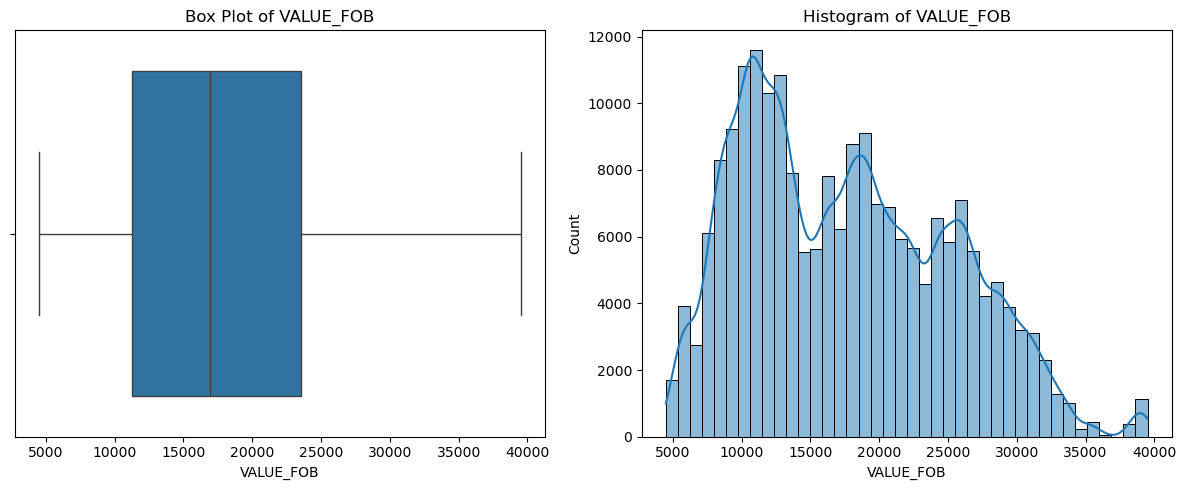

In [152]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot
sns.boxplot(x=df['VALUE_FOB'], ax=axes[0])
axes[0].set_title('Box Plot of VALUE_FOB')

# Histogram
sns.histplot(df["VALUE_FOB"], bins=40, kde=True, ax=axes[1])
axes[1].set_title('Histogram of VALUE_FOB')

plt.tight_layout()
plt.show()

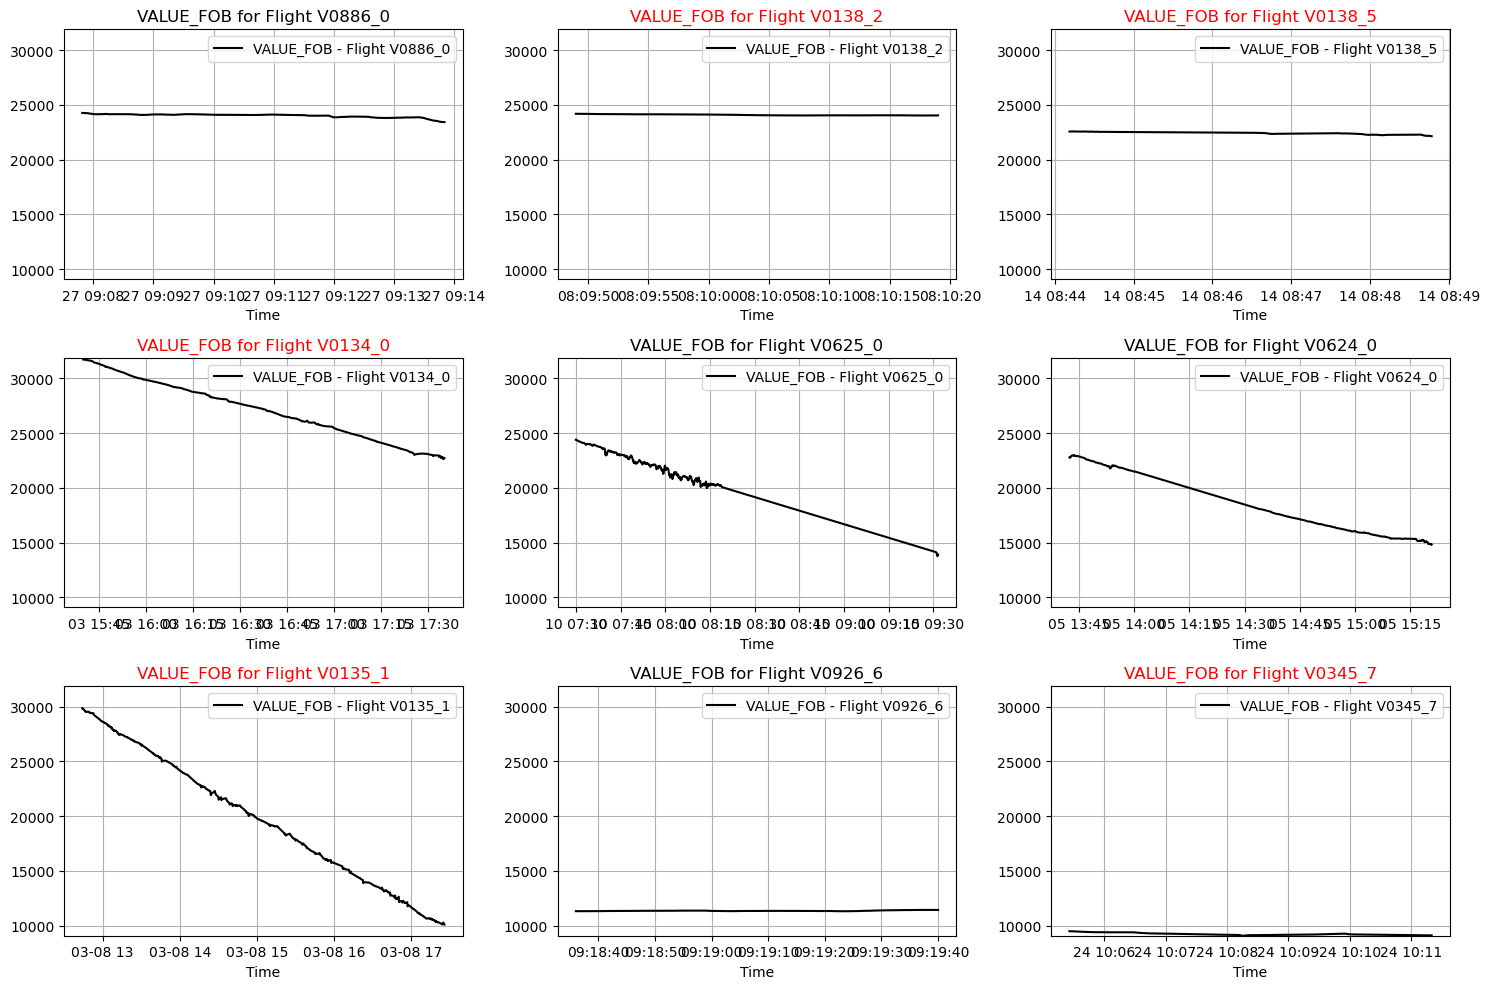

In [153]:
# Plotting VALUE_FOB in Unique Fights
# =======================================

y_min = df[df['FLIGHT_ID'].isin(flights_to_plot)]['VALUE_FOB'].min()
y_max = df[df['FLIGHT_ID'].isin(flights_to_plot)]['VALUE_FOB'].max()

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

# Unique flights with leaks
leak_flights = set(df.loc[df['LEAK_FLOW_FLAG'] == 1, 'FLIGHT_ID'].unique())

for idx, flight in enumerate(flights_to_plot):
    if idx >= len(axes):  # Avoid indexing error if there are more flights than subplot slots
        break
    
    flight_data = df[df['FLIGHT_ID'] == flight]
    
    ax = axes[idx]
    
    # Set title color to red if the flight has a leak, otherwise black
    title_color = 'red' if flight in leak_flights else 'black'
    
    ax.plot(flight_data.index, flight_data['VALUE_FOB'], label=f'VALUE_FOB - Flight {flight}', color='black')

    ax.legend()
    ax.set_title(f'VALUE_FOB for Flight {flight}', color=title_color)
    ax.set_xlabel('Time')
    ax.set_ylim(y_min, y_max)
    ax.grid(True)

plt.tight_layout()
plt.show()


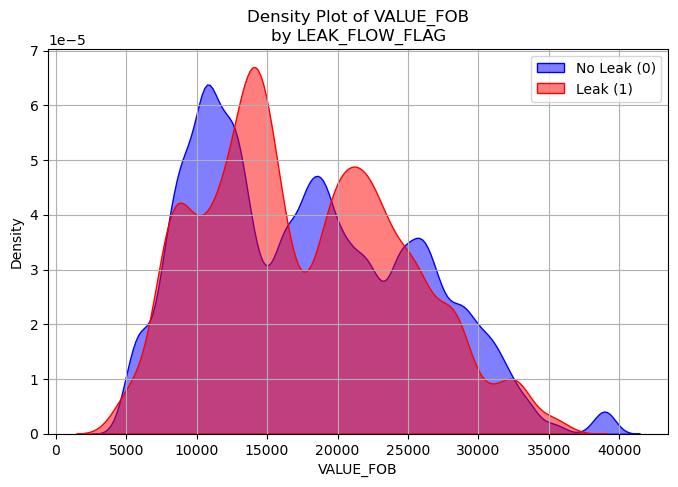

In [154]:
plt.figure(figsize=(8, 5))

sns.kdeplot(df[df['LEAK_FLOW_FLAG'] == 0]['VALUE_FOB'], 
            label="No Leak (0)", fill=True, alpha=0.5, color='blue')

sns.kdeplot(df[df['LEAK_FLOW_FLAG'] == 1]['VALUE_FOB'], 
            label="Leak (1)", fill=True, alpha=0.5, color='red')

plt.xlabel("VALUE_FOB")
plt.ylabel("Density")
plt.title("Density Plot of VALUE_FOB\nby LEAK_FLOW_FLAG")
plt.legend()
plt.grid(True)

plt.show()

## *With Engineered Features*

### Fuel Discrepancy `FOB_DIFFERENCE`

In [155]:
df['FOB_DIFFERENCE'].describe()

count    207967.000000
mean        809.529843
std        1897.869171
min           0.001000
25%          75.153000
50%         150.253000
75%         522.366000
max       15016.240000
Name: FOB_DIFFERENCE, dtype: float64

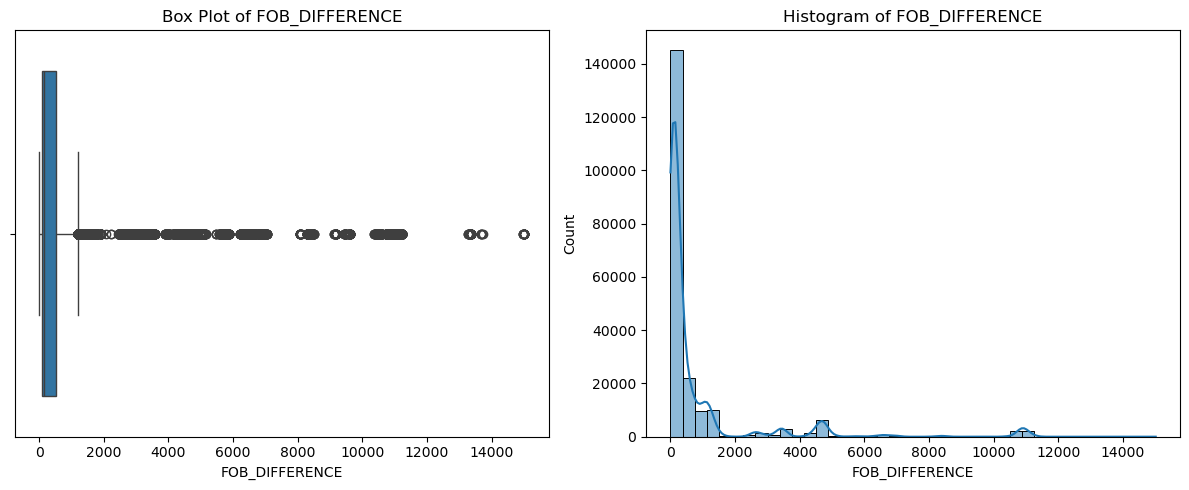

In [156]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot
sns.boxplot(x=df['FOB_DIFFERENCE'], ax=axes[0])
axes[0].set_title('Box Plot of FOB_DIFFERENCE')

# Histogram
sns.histplot(df["FOB_DIFFERENCE"], bins=40, kde=True, ax=axes[1])
axes[1].set_title('Histogram of FOB_DIFFERENCE')

plt.tight_layout()
plt.show()

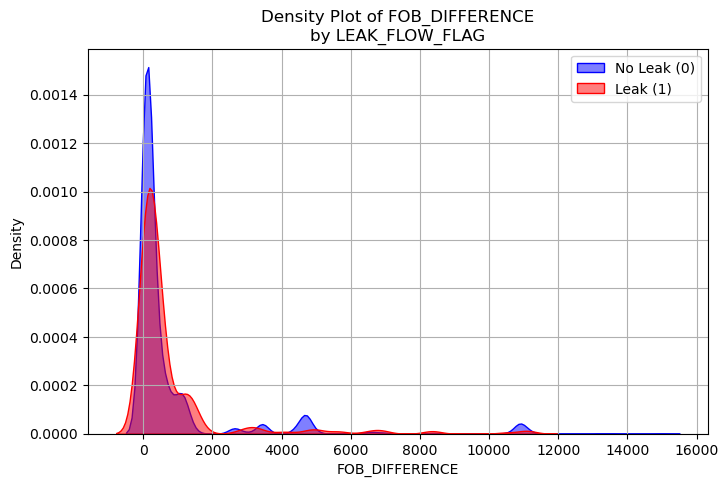

In [157]:
plt.figure(figsize=(8, 5))

sns.kdeplot(df[df['LEAK_FLOW_FLAG'] == 0]['FOB_DIFFERENCE'], 
            label="No Leak (0)", fill=True, alpha=0.5, color='blue')

sns.kdeplot(df[df['LEAK_FLOW_FLAG'] == 1]['FOB_DIFFERENCE'], 
            label="Leak (1)", fill=True, alpha=0.5, color='red')

plt.xlabel("FOB_DIFFERENCE")
plt.ylabel("Density")
plt.title("Density Plot of FOB_DIFFERENCE\nby LEAK_FLOW_FLAG")
plt.legend()
plt.grid(True)

plt.show()

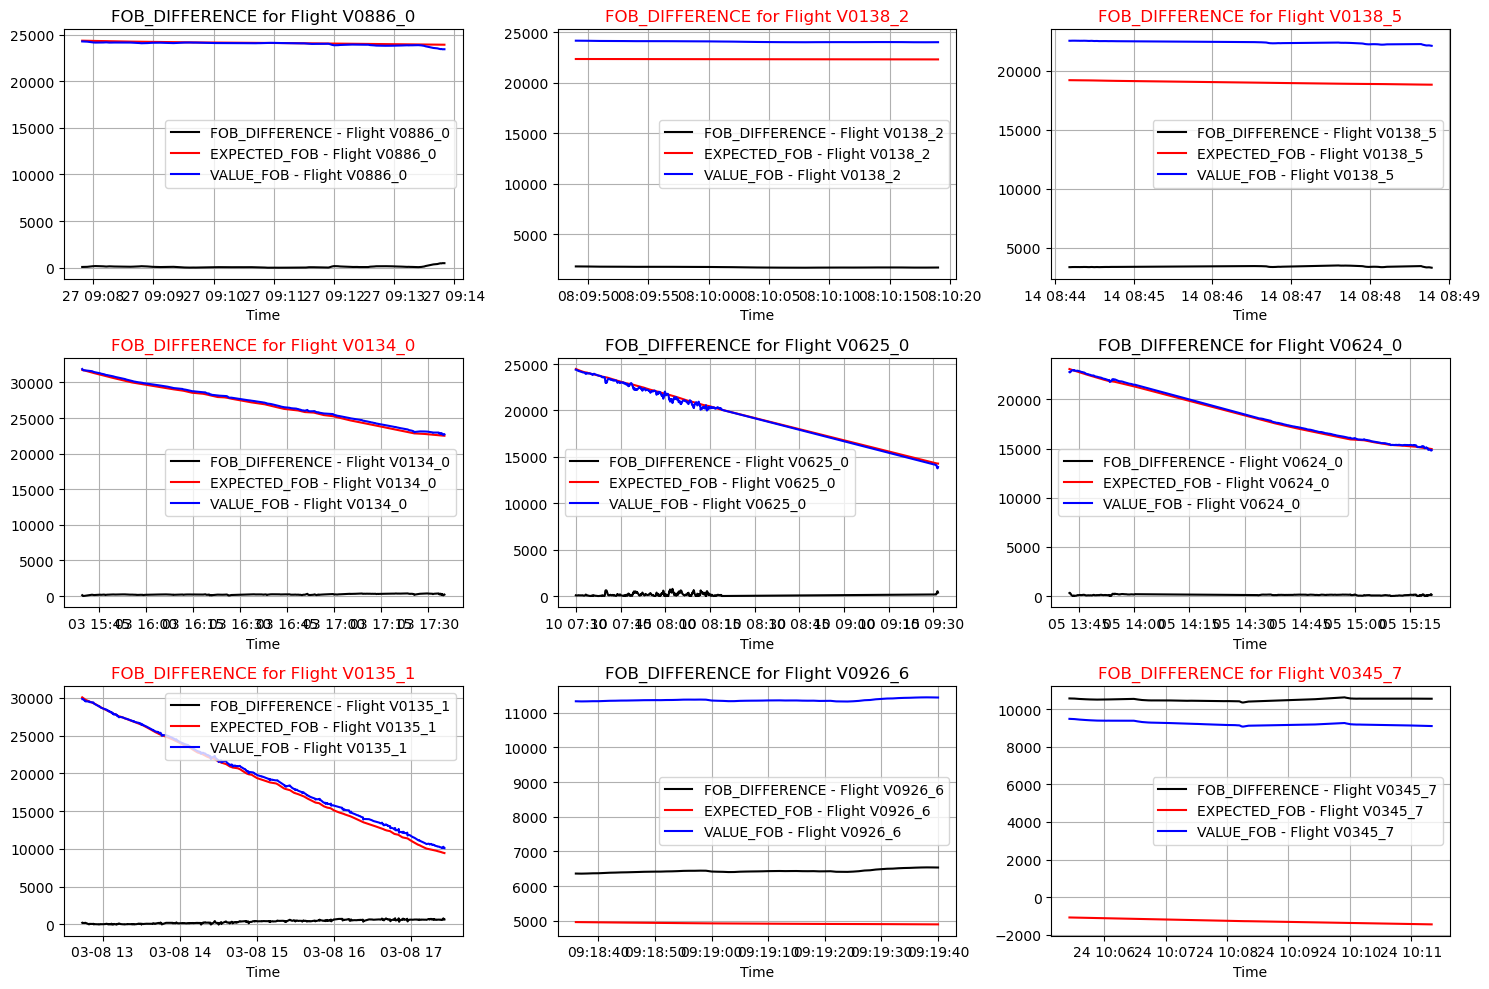

In [158]:
# Plotting VALUE_FOB in Unique Fights
# =======================================

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

# Unique flights with leaks
leak_flights = set(df.loc[df['LEAK_FLOW_FLAG'] == 1, 'FLIGHT_ID'].unique())

for idx, flight in enumerate(flights_to_plot):  # skipping the first flight
    if idx >= len(axes):  # Avoid indexing error if there are more flights than subplot slots
        break
    
    flight_data = df[df['FLIGHT_ID'] == flight]
    
    ax = axes[idx]
    
    # Set title color to red if the flight has a leak, otherwise black
    title_color = 'red' if flight in leak_flights else 'black'
    
    ax.plot(flight_data.index, flight_data['FOB_DIFFERENCE'], label=f'FOB_DIFFERENCE - Flight {flight}', color='black')
    ax.plot(flight_data.index, flight_data['EXPECTED_FOB'], label=f'EXPECTED_FOB - Flight {flight}', color='red')
    ax.plot(flight_data.index, flight_data['VALUE_FOB'], label=f'VALUE_FOB - Flight {flight}', color='blue')

    ax.legend()
    ax.set_title(f'FOB_DIFFERENCE for Flight {flight}', color=title_color)
    ax.set_xlabel('Time')
    ax.grid(True)

plt.tight_layout()
plt.show()


### `FUEL_LEAK_RATE`

In [159]:
df['FUEL_LEAK_RATE'].describe()

count    207967.000000
mean         -0.104219
std         110.645421
min      -18927.952000
25%          -1.391000
50%           0.008000
75%           1.614000
max       16802.601950
Name: FUEL_LEAK_RATE, dtype: float64

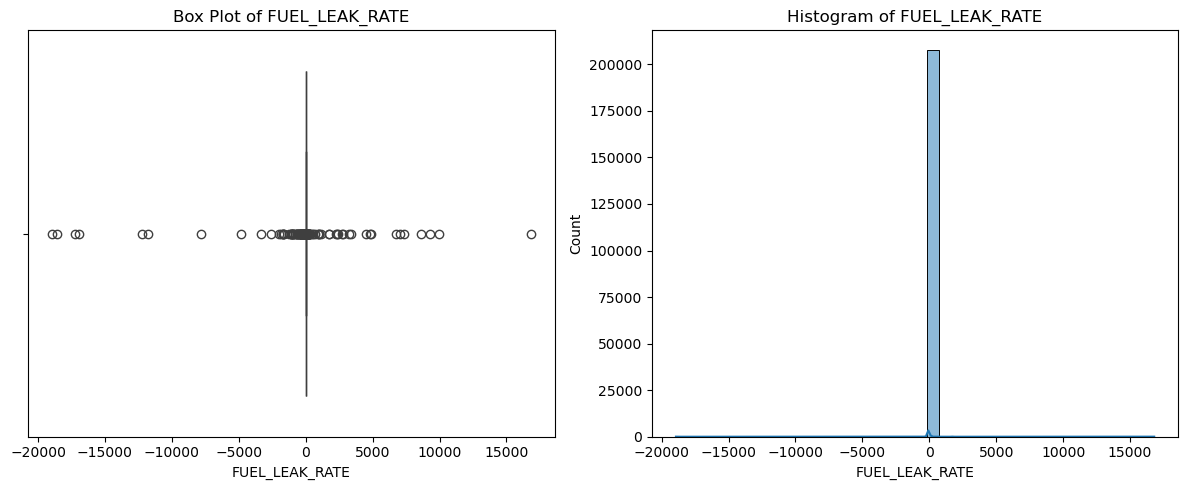

In [160]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot
sns.boxplot(x=df['FUEL_LEAK_RATE'], ax=axes[0])
axes[0].set_title('Box Plot of FUEL_LEAK_RATE')

# Histogram
sns.histplot(df["FUEL_LEAK_RATE"], bins=40, kde=True, ax=axes[1])
axes[1].set_title('Histogram of FUEL_LEAK_RATE')

plt.tight_layout()
plt.show()

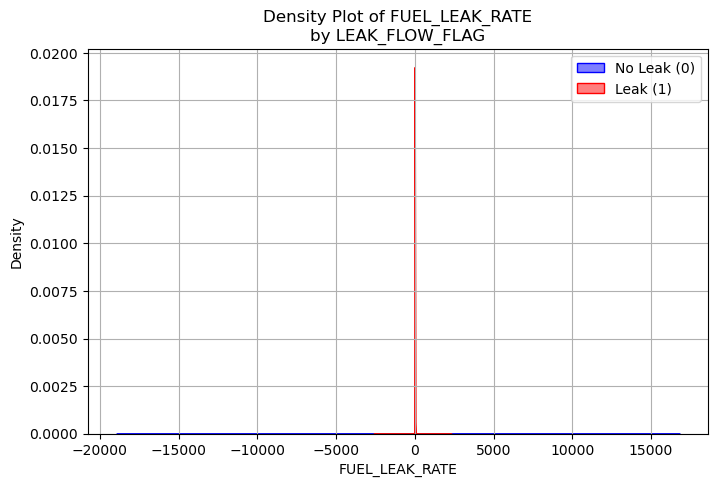

In [161]:
plt.figure(figsize=(8, 5))

sns.kdeplot(df[df['LEAK_FLOW_FLAG'] == 0]['FUEL_LEAK_RATE'], 
            label="No Leak (0)", fill=True, alpha=0.5, color='blue')

sns.kdeplot(df[df['LEAK_FLOW_FLAG'] == 1]['FUEL_LEAK_RATE'], 
            label="Leak (1)", fill=True, alpha=0.5, color='red')

plt.xlabel("FUEL_LEAK_RATE")
plt.ylabel("Density")
plt.title("Density Plot of FUEL_LEAK_RATE\nby LEAK_FLOW_FLAG")
plt.legend()
plt.grid(True)

plt.show()

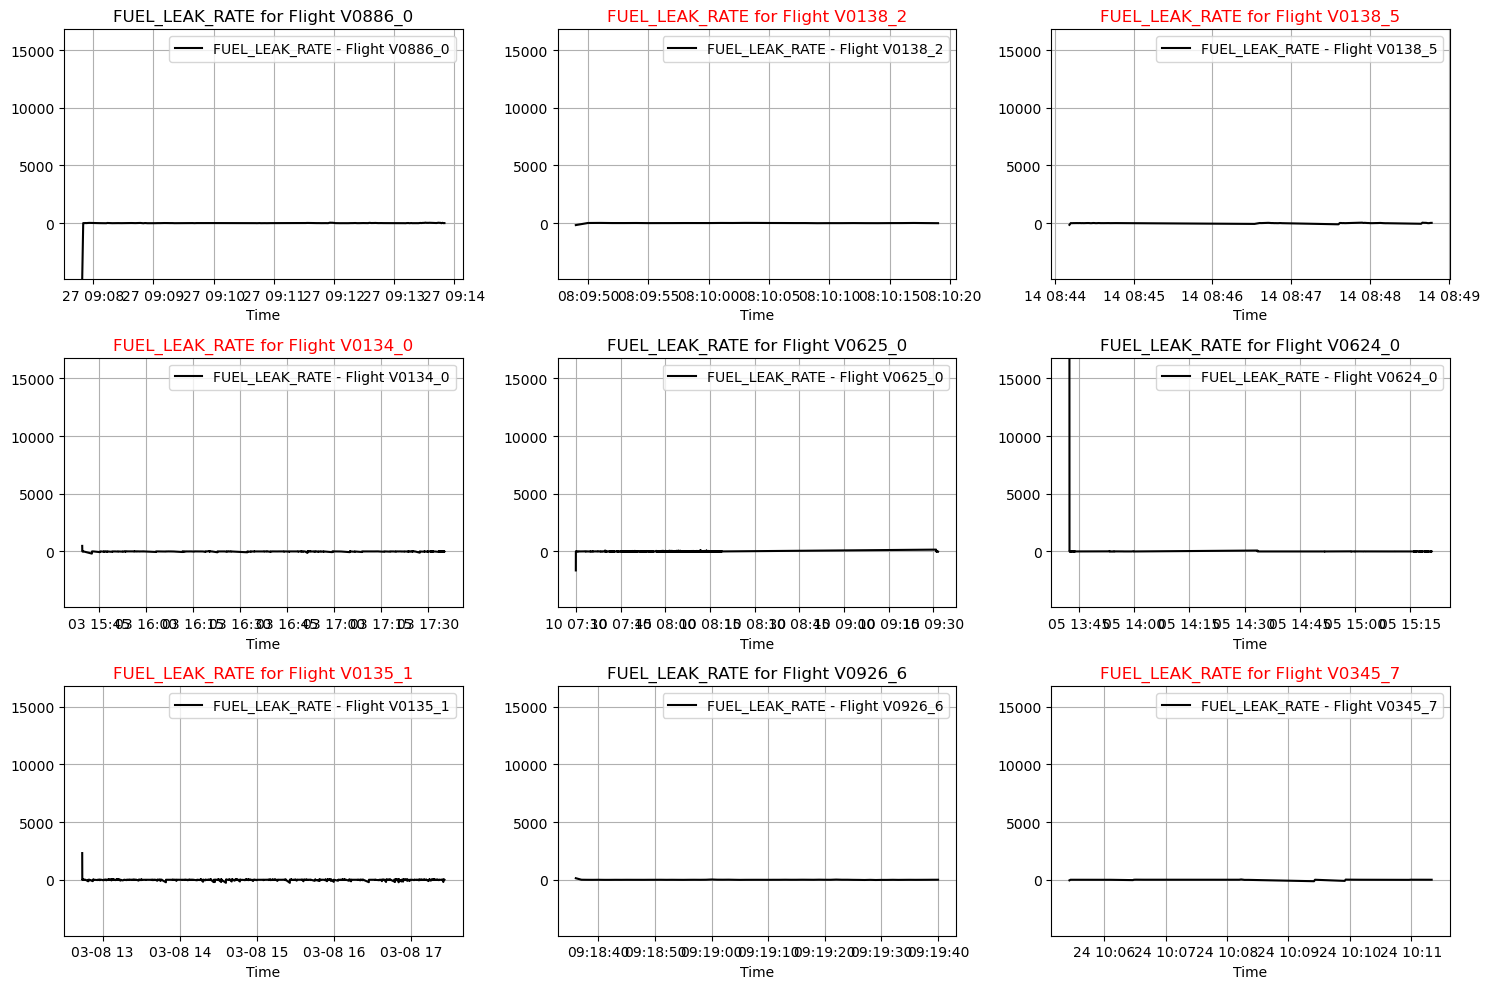

In [162]:
y_min = df[df['FLIGHT_ID'].isin(flights_to_plot)]['FUEL_LEAK_RATE'].min()
y_max = df[df['FLIGHT_ID'].isin(flights_to_plot)]['FUEL_LEAK_RATE'].max()

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

# For each unique flight
for idx, flight in enumerate(flights_to_plot):  
    if idx >= len(axes):  # Avoid indexing error if there are more flights than subplot slots
        break
    
    flight_data = df[df['FLIGHT_ID'] == flight]
    ax = axes[idx]
    
    # Set title color to red if the flight has a leak, otherwise black
    title_color = 'red' if flight in leak_flights else 'black'
    
    ax.plot(flight_data.index, flight_data['FUEL_LEAK_RATE'], 
            label=f'FUEL_LEAK_RATE - Flight {flight}', color='black')
    
    ax.legend()
    ax.set_title(f'FUEL_LEAK_RATE for Flight {flight}', color=title_color)
    ax.set_xlabel('Time')
    ax.set_ylim(y_min, y_max)
    ax.grid(True)

plt.tight_layout()
plt.show()

### Left Wing, Right Wing Discrepancy

In [163]:
# Total Fuel in Left and Right Wing
df['TOTAL_FUEL_LW'] = (df['VALUE_FUEL_QTY_LXT'] + df['VALUE_FUEL_QTY_FT1'] + df['VALUE_FUEL_QTY_FT2'])
df['TOTAL_FUEL_RW'] = (df['VALUE_FUEL_QTY_RXT'] + df['VALUE_FUEL_QTY_FT3'] + df['VALUE_FUEL_QTY_FT4'])

# Fuel Difference
df['LW_RW_DIFF'] = (df['TOTAL_FUEL_LW'] - df['TOTAL_FUEL_RW']).abs()

In [164]:
df['LW_RW_DIFF'].describe()

count    207967.000000
mean        436.131353
std         785.501680
min           0.000000
25%          68.000000
50%         151.000000
75%         431.000000
max        4895.000000
Name: LW_RW_DIFF, dtype: float64

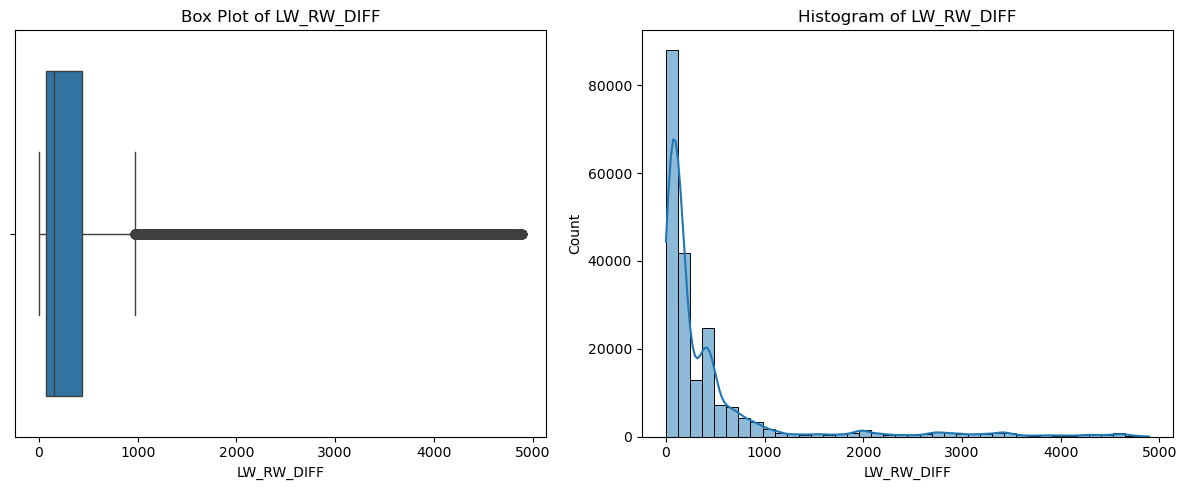

In [165]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot
sns.boxplot(x=df['LW_RW_DIFF'], ax=axes[0])
axes[0].set_title('Box Plot of LW_RW_DIFF')

# Histogram
sns.histplot(df["LW_RW_DIFF"], bins=40, kde=True, ax=axes[1])
axes[1].set_title('Histogram of LW_RW_DIFF')

plt.tight_layout()
plt.show()

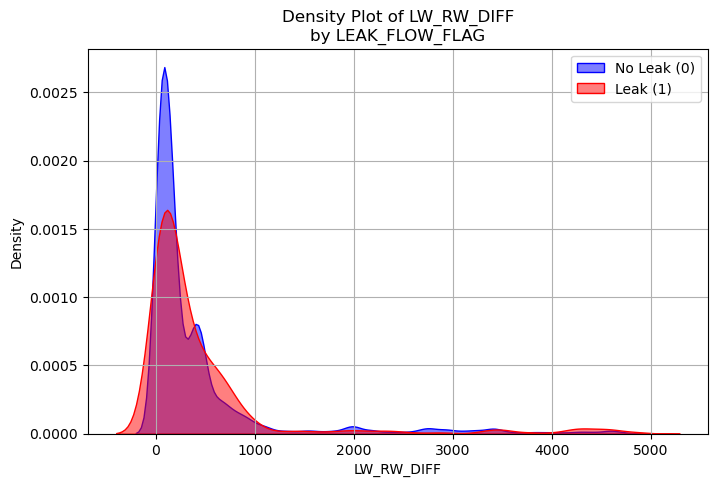

In [166]:
plt.figure(figsize=(8, 5))

sns.kdeplot(df[df['LEAK_FLOW_FLAG'] == 0]['LW_RW_DIFF'], 
            label="No Leak (0)", fill=True, alpha=0.5, color='blue')

sns.kdeplot(df[df['LEAK_FLOW_FLAG'] == 1]['LW_RW_DIFF'], 
            label="Leak (1)", fill=True, alpha=0.5, color='red')

plt.xlabel("LW_RW_DIFF")
plt.ylabel("Density")
plt.title("Density Plot of LW_RW_DIFF\nby LEAK_FLOW_FLAG")
plt.legend()
plt.grid(True)

plt.show()

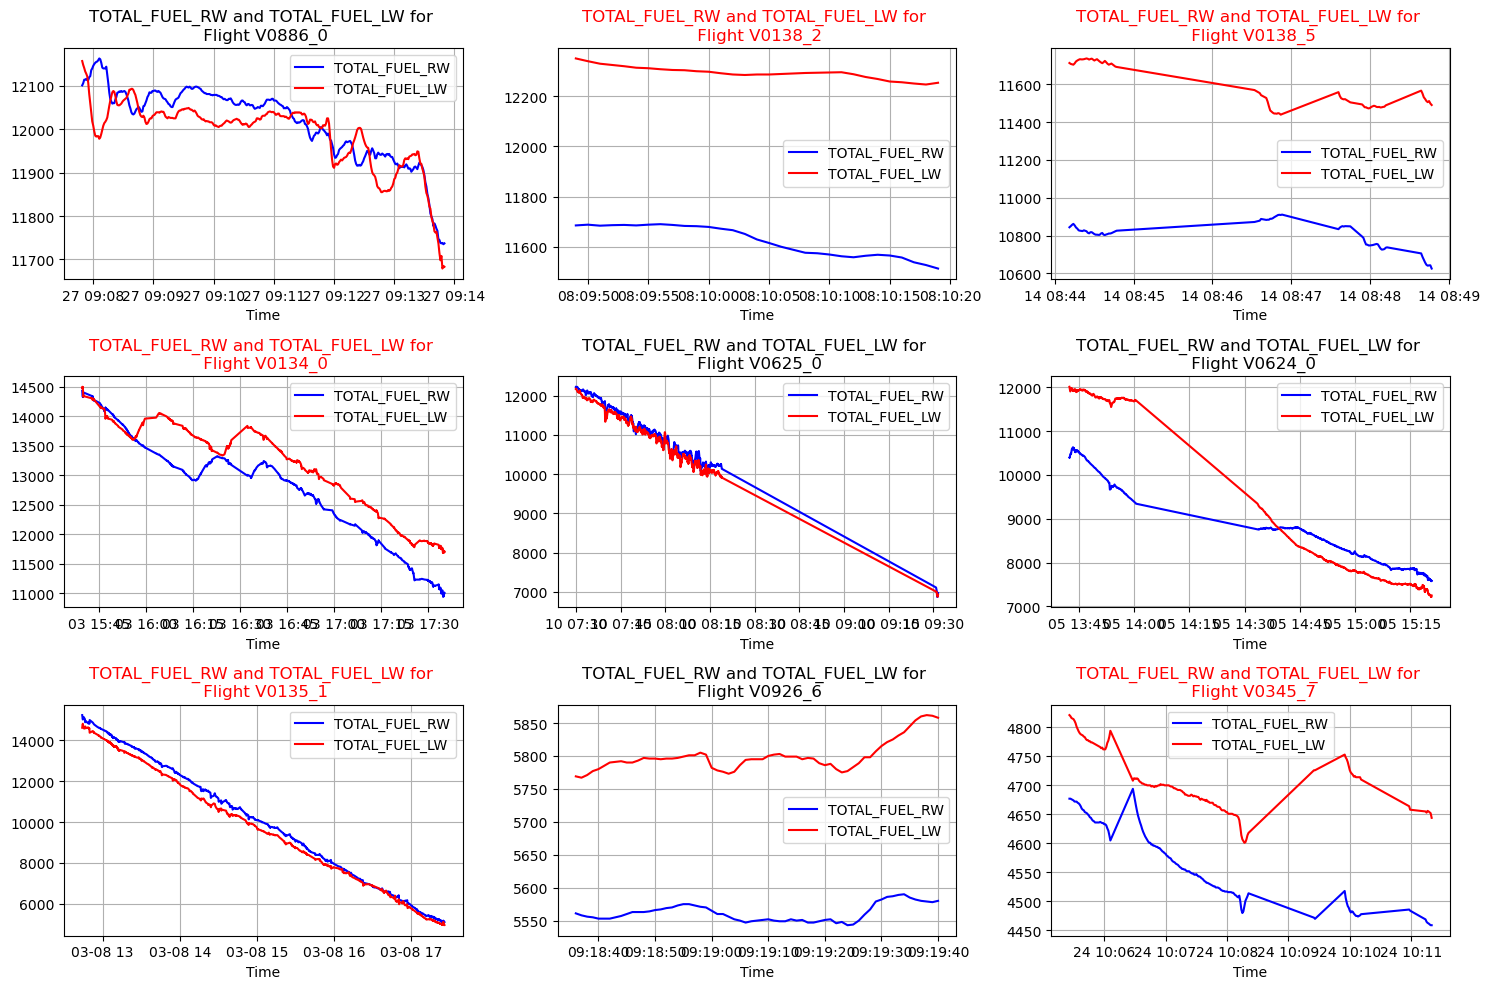

In [167]:
# Left Wing vs Right Wing Fuel Imbalance
# ======================================

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

# Unique flights with leaks
leak_flights = set(df.loc[df['LEAK_FLOW_FLAG'] == 1, 'FLIGHT_ID'].unique())

for idx, flight in enumerate(flights_to_plot):  # skipping the first flight
    if idx >= len(axes):  # Avoid indexing error if there are more flights than subplot slots
        break
    
    flight_data = df[df['FLIGHT_ID'] == flight]
    
    ax = axes[idx]
    
    # Set title color to red if the flight has a leak, otherwise black
    title_color = 'red' if flight in leak_flights else 'black'
    
    # Plot TOTAL_FUEL_RW vs TOTAL_FUEL_LW
    ax.plot(flight_data.index, flight_data['TOTAL_FUEL_RW'], label='TOTAL_FUEL_RW', color='blue')
    ax.plot(flight_data.index, flight_data['TOTAL_FUEL_LW'], label='TOTAL_FUEL_LW', color='red')
    
    ax.legend()
    ax.set_title(f'TOTAL_FUEL_RW and TOTAL_FUEL_LW for \n Flight {flight}', color=title_color)
    ax.set_xlabel('Time')
    ax.grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

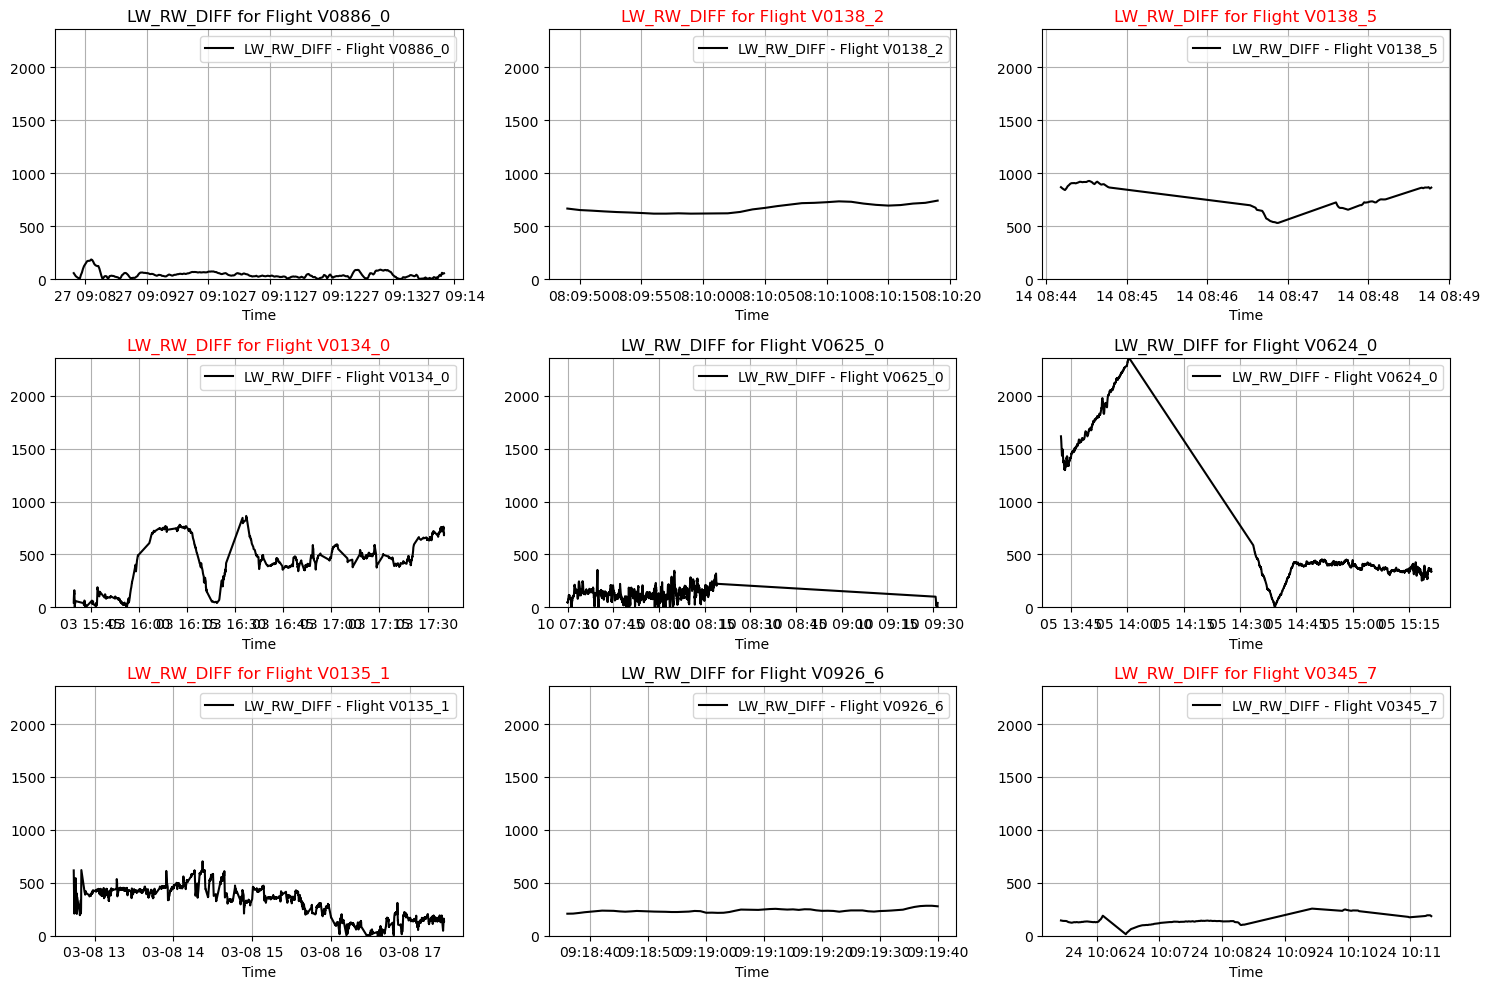

In [168]:
y_min = df[df['FLIGHT_ID'].isin(flights_to_plot)]['LW_RW_DIFF'].min()
y_max = df[df['FLIGHT_ID'].isin(flights_to_plot)]['LW_RW_DIFF'].max()

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

# For each unique flight
for idx, flight in enumerate(flights_to_plot):  
    if idx >= len(axes):  # Avoid indexing error if there are more flights than subplot slots
        break
    
    flight_data = df[df['FLIGHT_ID'] == flight]
    ax = axes[idx]
    
    # Set title color to red if the flight has a leak, otherwise black
    title_color = 'red' if flight in leak_flights else 'black'
    
    ax.plot(flight_data.index, flight_data['LW_RW_DIFF'], 
            label=f'LW_RW_DIFF - Flight {flight}', color='black')
    
    ax.legend()
    ax.set_title(f'LW_RW_DIFF for Flight {flight}', color=title_color)
    ax.set_xlabel('Time')
    ax.set_ylim(y_min, y_max)
    ax.grid(True)

plt.tight_layout()
plt.show()

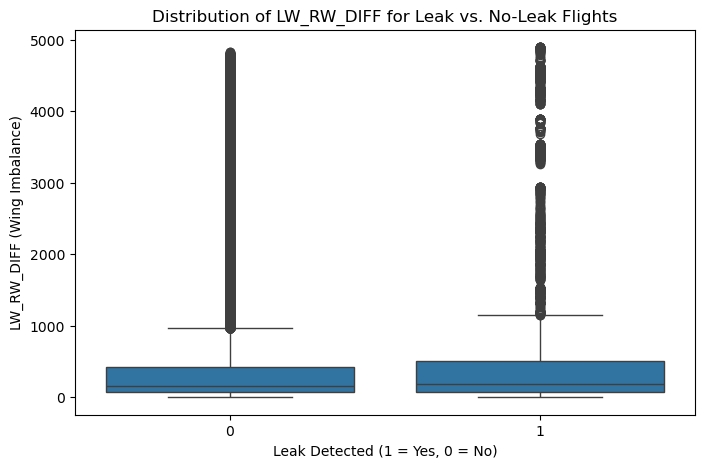

In [169]:
plt.figure(figsize=(8, 5))
sns.boxplot(x=df['LEAK_FLOW_FLAG'], y=df['LW_RW_DIFF'])
plt.xlabel('Leak Detected (1 = Yes, 0 = No)')
plt.ylabel('LW_RW_DIFF (Wing Imbalance)')
plt.title('Distribution of LW_RW_DIFF for Leak vs. No-Leak Flights')
plt.show()

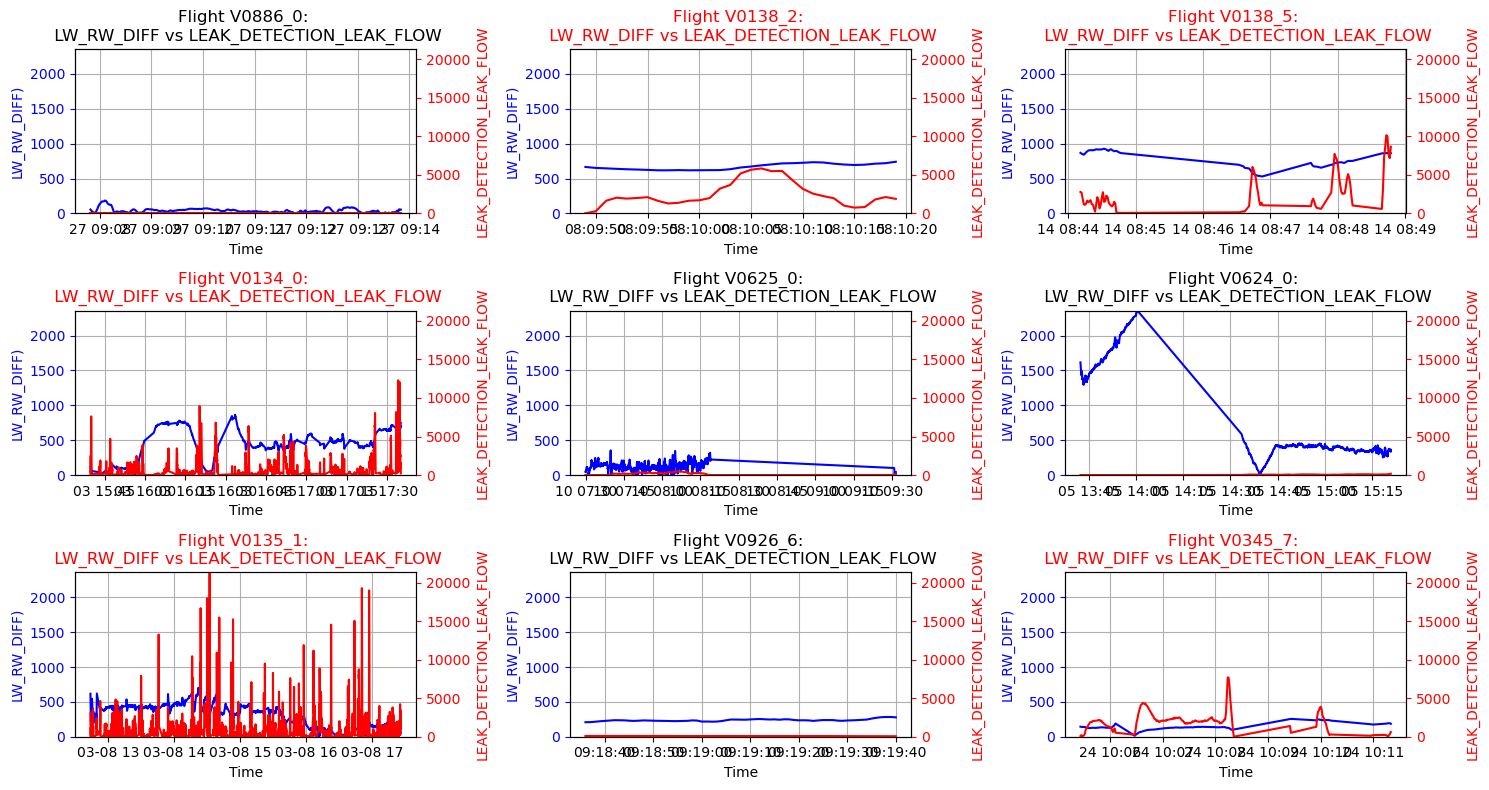

In [170]:
y1_min = df[df['FLIGHT_ID'].isin(flights_to_plot)]['LW_RW_DIFF'].min()
y1_max = df[df['FLIGHT_ID'].isin(flights_to_plot)]['LW_RW_DIFF'].max()

y2_min = df[df['FLIGHT_ID'].isin(flights_to_plot)]['LEAK_DETECTION_LEAK_FLOW'].min()
y2_max = df[df['FLIGHT_ID'].isin(flights_to_plot)]['LEAK_DETECTION_LEAK_FLOW'].max()

fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
axes = axes.flatten()

for idx, flight in enumerate(flights_to_plot):  
    if idx >= len(axes):  # Avoid indexing error if there are more flights than subplot spaces
        break
    
    flight_data = df[df['FLIGHT_ID'] == flight]
    ax = axes[idx]
    ax2 = ax.twinx()  # Create secondary y-axis

    # Set title color to red if the flight has a leak, otherwise black
    title_color = 'red' if flight in leak_flights else 'black'
    
    # Plot Left-Right Wing Fuel Difference (LW_RW_DIFF) on primary (left) y-axis
    ax.plot(flight_data.index, flight_data['LW_RW_DIFF'], color='blue', label='LW_RW_DIFF')
    ax.set_ylabel('LW_RW_DIFF)', color='blue')
    ax.tick_params(axis='y', colors='blue')
    ax.set_ylim(y1_min, y1_max)

    # Plot Leak Detection Leak Flow on secondary (right) y-axis
    ax2.plot(flight_data.index, flight_data['LEAK_DETECTION_LEAK_FLOW'], color='red', label='LEAK_DETECTION_LEAK_FLOW')
    ax2.set_ylabel('LEAK_DETECTION_LEAK_FLOW', color='red')
    ax2.tick_params(axis='y', colors='red')
    ax2.set_ylim(y2_min, y2_max)

    # Title formatting
    ax.set_title(f'Flight {flight}: \n LW_RW_DIFF vs LEAK_DETECTION_LEAK_FLOW', color=title_color)
    ax.set_xlabel('Time')
    ax.grid(True)

plt.tight_layout()
plt.show()


### Discrepancy between given `VALUE_FOB` and our own calcuations of fuel on board `FUEL_IN_TANKS`

In [171]:
df['CALC_VALUE_FOB_DIFF'].describe()

count    207967.000000
mean          1.887689
std           2.227227
min         -73.000000
25%           1.000000
50%           2.000000
75%           3.000000
max          38.000000
Name: CALC_VALUE_FOB_DIFF, dtype: float64

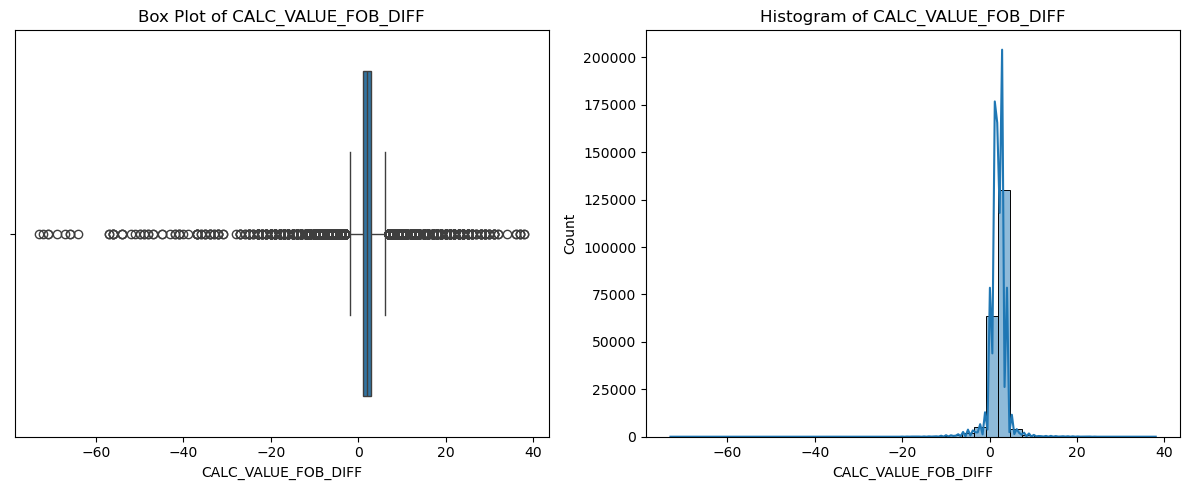

In [172]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot
sns.boxplot(x=df['CALC_VALUE_FOB_DIFF'], ax=axes[0])
axes[0].set_title('Box Plot of CALC_VALUE_FOB_DIFF')

# Histogram
sns.histplot(df["CALC_VALUE_FOB_DIFF"], bins=40, kde=True, ax=axes[1])
axes[1].set_title('Histogram of CALC_VALUE_FOB_DIFF')

plt.tight_layout()
plt.show()

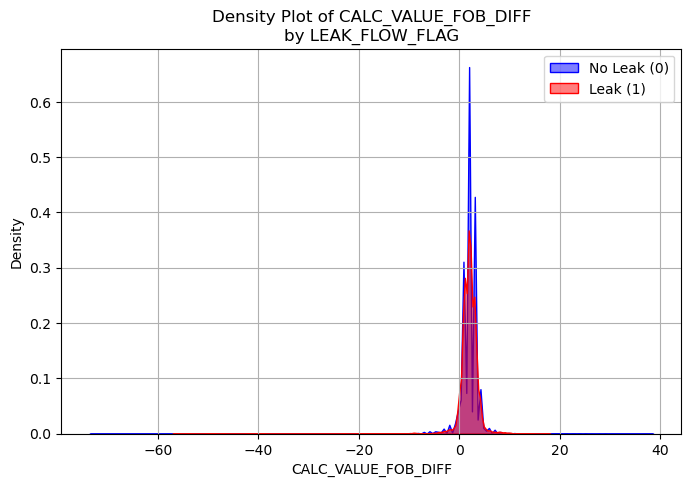

In [173]:
plt.figure(figsize=(8, 5))

sns.kdeplot(df[df['LEAK_FLOW_FLAG'] == 0]['CALC_VALUE_FOB_DIFF'], 
            label="No Leak (0)", fill=True, alpha=0.5, color='blue')

sns.kdeplot(df[df['LEAK_FLOW_FLAG'] == 1]['CALC_VALUE_FOB_DIFF'], 
            label="Leak (1)", fill=True, alpha=0.5, color='red')

plt.xlabel("CALC_VALUE_FOB_DIFF")
plt.ylabel("Density")
plt.title("Density Plot of CALC_VALUE_FOB_DIFF\nby LEAK_FLOW_FLAG")
plt.legend()
plt.grid(True)

plt.show()

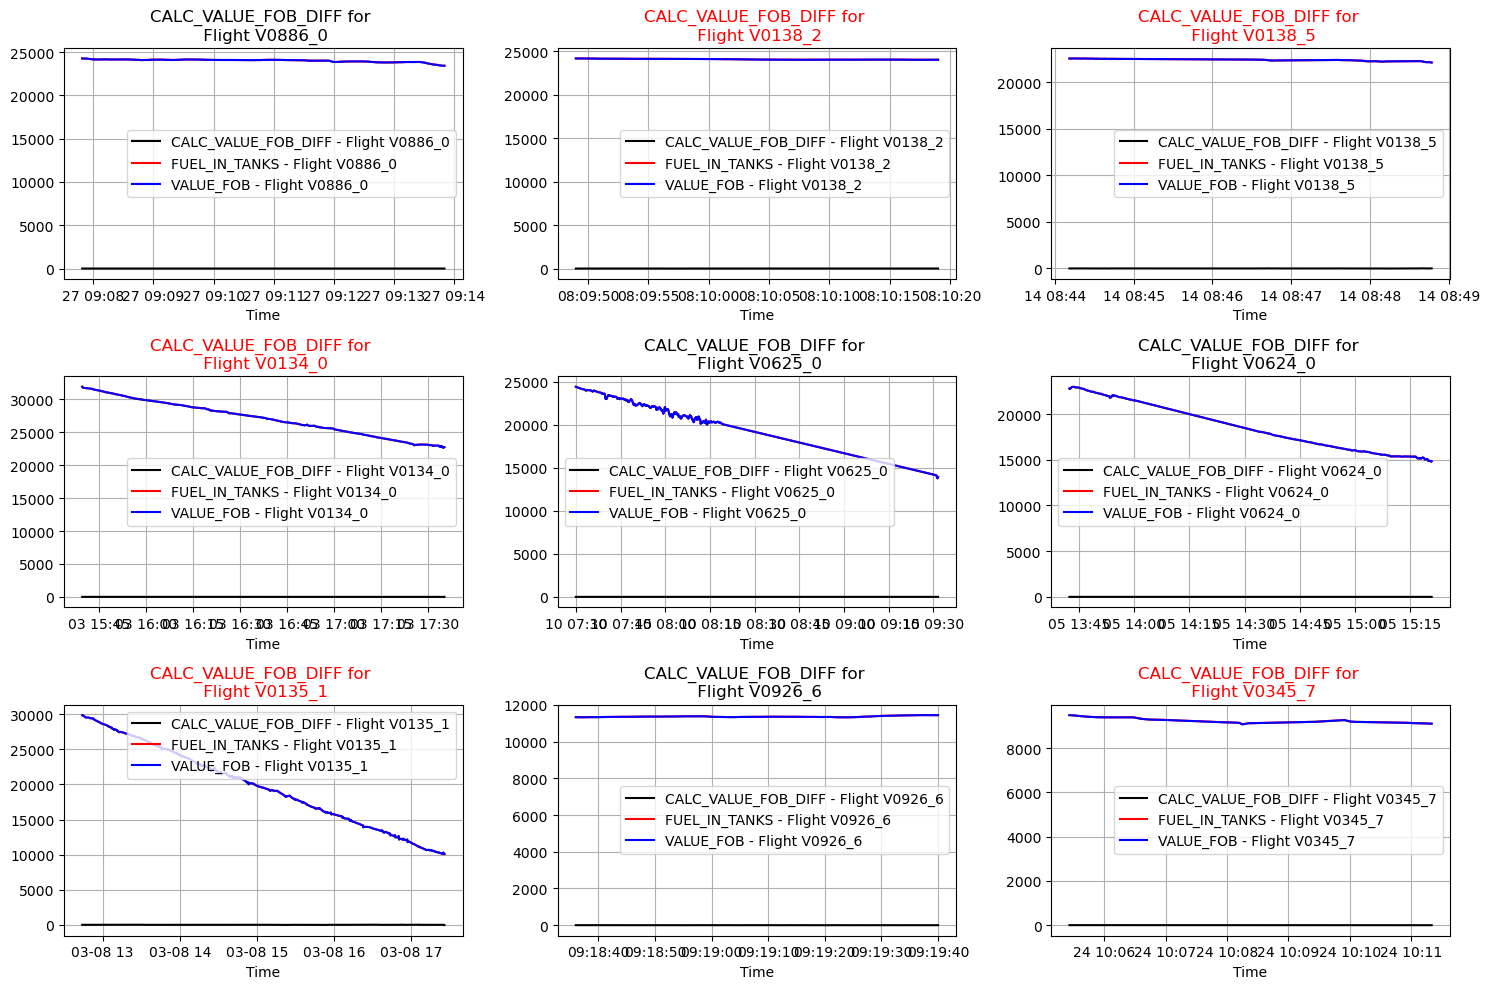

In [174]:
# Plotting CALC_VALUE_FOB_DIFF in Unique Fights
# =======================================

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

# Unique flights with leaks
leak_flights = set(df.loc[df['LEAK_FLOW_FLAG'] == 1, 'FLIGHT_ID'].unique())

for idx, flight in enumerate(flights_to_plot): 
    if idx >= len(axes):  # Avoid indexing error if there are more flights than subplot slots
        break
    
    flight_data = df[df['FLIGHT_ID'] == flight]
    
    ax = axes[idx]
    
    # Set title color to red if the flight has a leak, otherwise black
    title_color = 'red' if flight in leak_flights else 'black'
    
    ax.plot(flight_data.index, flight_data['CALC_VALUE_FOB_DIFF'], label=f'CALC_VALUE_FOB_DIFF - Flight {flight}', color='black')
    ax.plot(flight_data.index, flight_data['FUEL_IN_TANKS'], label=f'FUEL_IN_TANKS - Flight {flight}', color='red')
    ax.plot(flight_data.index, flight_data['VALUE_FOB'], label=f'VALUE_FOB - Flight {flight}', color='blue')

    ax.legend()
    ax.set_title(f'CALC_VALUE_FOB_DIFF for \n Flight {flight}', color=title_color)
    ax.set_xlabel('Time')
    ax.grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

### `TOTAL_FUEL_USED`

In [175]:
df['TOTAL_FUEL_USED'].describe()

count    207967.000000
mean       8876.379134
std        5461.466544
min         329.657980
25%        4481.113000
50%        8134.876000
75%       12969.583500
max       22478.552000
Name: TOTAL_FUEL_USED, dtype: float64

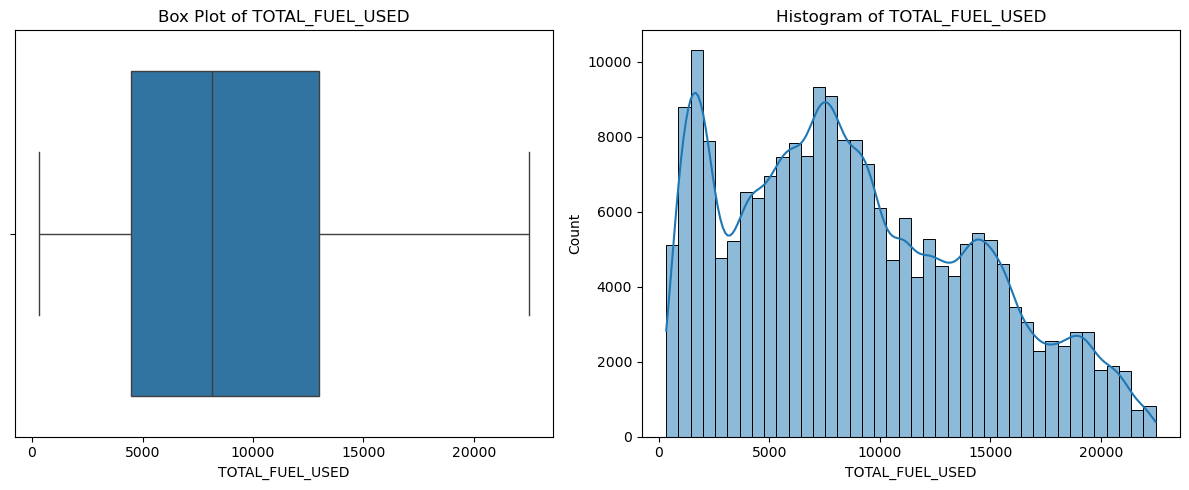

In [176]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot
sns.boxplot(x=df['TOTAL_FUEL_USED'], ax=axes[0])
axes[0].set_title('Box Plot of TOTAL_FUEL_USED')

# Histogram
sns.histplot(df["TOTAL_FUEL_USED"], bins=40, kde=True, ax=axes[1])
axes[1].set_title('Histogram of TOTAL_FUEL_USED')

plt.tight_layout()
plt.show()

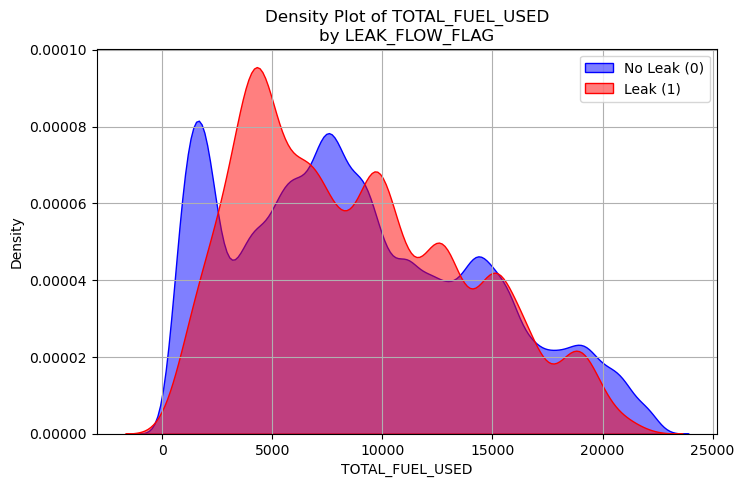

In [177]:
plt.figure(figsize=(8, 5))

sns.kdeplot(df[df['LEAK_FLOW_FLAG'] == 0]['TOTAL_FUEL_USED'], 
            label="No Leak (0)", fill=True, alpha=0.5, color='blue')

sns.kdeplot(df[df['LEAK_FLOW_FLAG'] == 1]['TOTAL_FUEL_USED'], 
            label="Leak (1)", fill=True, alpha=0.5, color='red')

plt.xlabel("TOTAL_FUEL_USED")
plt.ylabel("Density")
plt.title("Density Plot of TOTAL_FUEL_USED\nby LEAK_FLOW_FLAG")
plt.legend()
plt.grid(True)

plt.show()

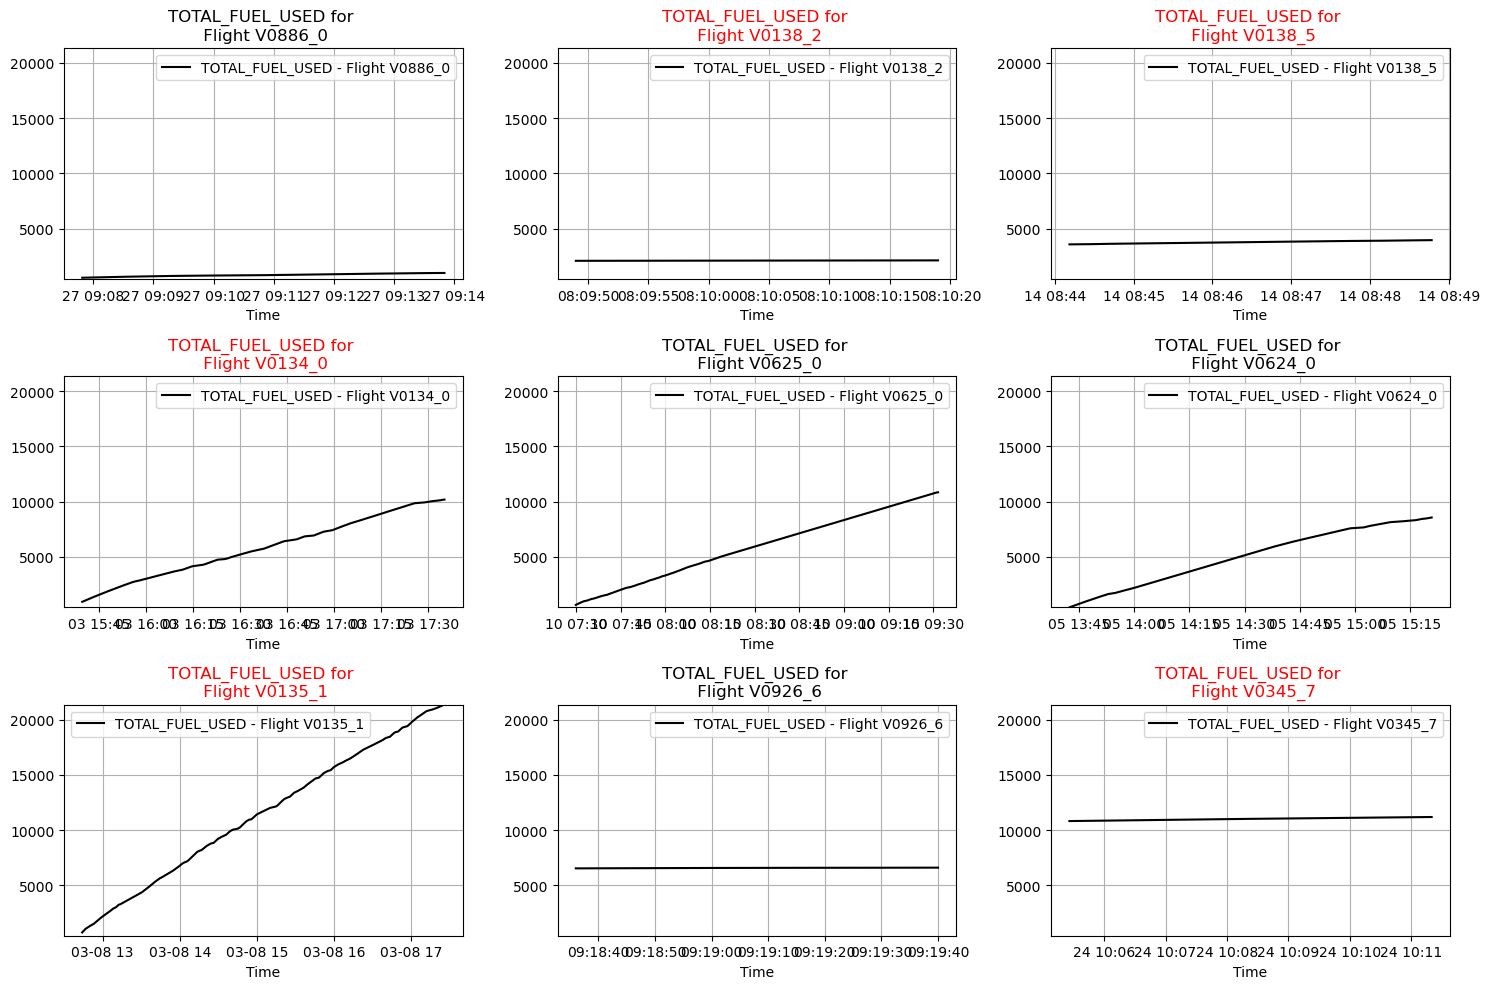

In [178]:
# Plotting TOTAL_FUEL_USED in Unique Fights
# =======================================

y_min = df[df['FLIGHT_ID'].isin(flights_to_plot)]['TOTAL_FUEL_USED'].min()
y_max = df[df['FLIGHT_ID'].isin(flights_to_plot)]['TOTAL_FUEL_USED'].max()

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

# Unique flights with leaks
leak_flights = set(df.loc[df['LEAK_FLOW_FLAG'] == 1, 'FLIGHT_ID'].unique())

for idx, flight in enumerate(flights_to_plot):  # skipping the first flight
    if idx >= len(axes):  # Avoid indexing error if there are more flights than subplot slots
        break
    
    flight_data = df[df['FLIGHT_ID'] == flight]
    
    ax = axes[idx]
    
    # Set title color to red if the flight has a leak, otherwise black
    title_color = 'red' if flight in leak_flights else 'black'
    
    ax.plot(flight_data.index, flight_data['TOTAL_FUEL_USED'], label=f'TOTAL_FUEL_USED - Flight {flight}', color='black')

    ax.legend()
    ax.set_title(f'TOTAL_FUEL_USED for \n Flight {flight}', color=title_color)
    ax.set_xlabel('Time')
    ax.set_ylim(y_min, y_max)
    ax.grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

### `START_FOB_VS_FOB_FUELUSED`

In [179]:
df['START_FOB_VS_FOB_FUELUSED'].describe()

count    207967.000000
mean       -529.707869
std        1994.745377
min      -15018.240000
25%        -210.307350
50%         -26.398000
75%         119.439000
max        2226.067000
Name: START_FOB_VS_FOB_FUELUSED, dtype: float64

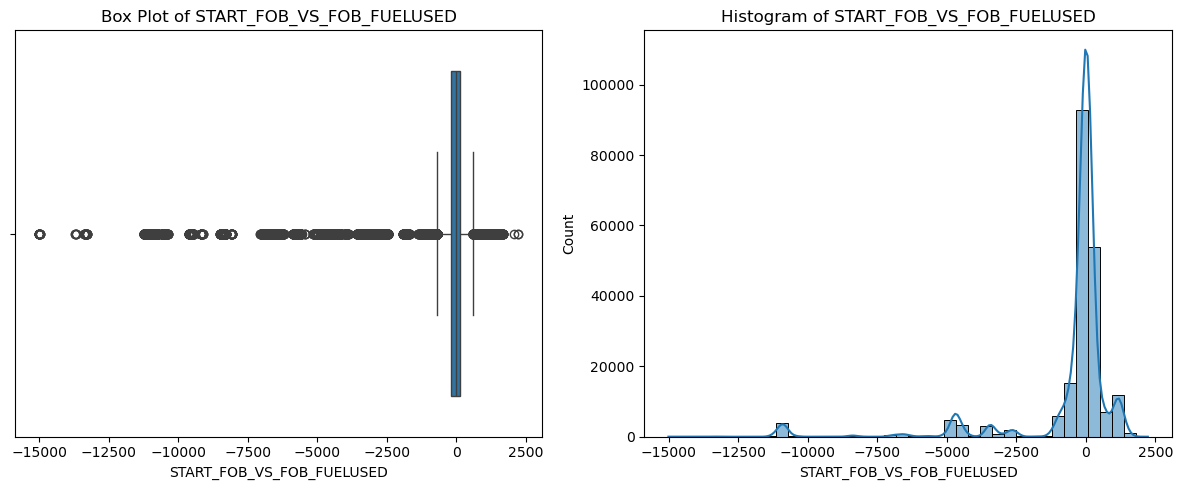

In [180]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot
sns.boxplot(x=df['START_FOB_VS_FOB_FUELUSED'], ax=axes[0])
axes[0].set_title('Box Plot of START_FOB_VS_FOB_FUELUSED')

# Histogram
sns.histplot(df["START_FOB_VS_FOB_FUELUSED"], bins=40, kde=True, ax=axes[1])
axes[1].set_title('Histogram of START_FOB_VS_FOB_FUELUSED')

plt.tight_layout()
plt.show()

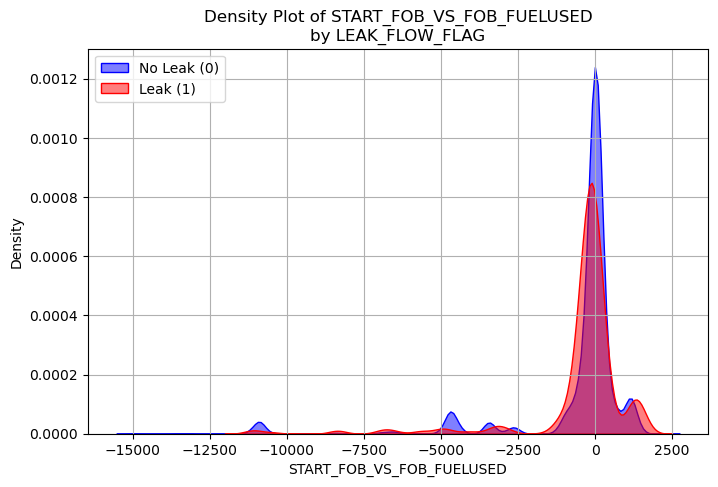

In [181]:
plt.figure(figsize=(8, 5))

sns.kdeplot(df[df['LEAK_FLOW_FLAG'] == 0]['START_FOB_VS_FOB_FUELUSED'], 
            label="No Leak (0)", fill=True, alpha=0.5, color='blue')

sns.kdeplot(df[df['LEAK_FLOW_FLAG'] == 1]['START_FOB_VS_FOB_FUELUSED'], 
            label="Leak (1)", fill=True, alpha=0.5, color='red')

plt.xlabel("START_FOB_VS_FOB_FUELUSED")
plt.ylabel("Density")
plt.title("Density Plot of START_FOB_VS_FOB_FUELUSED\nby LEAK_FLOW_FLAG")
plt.legend()
plt.grid(True)

plt.show()

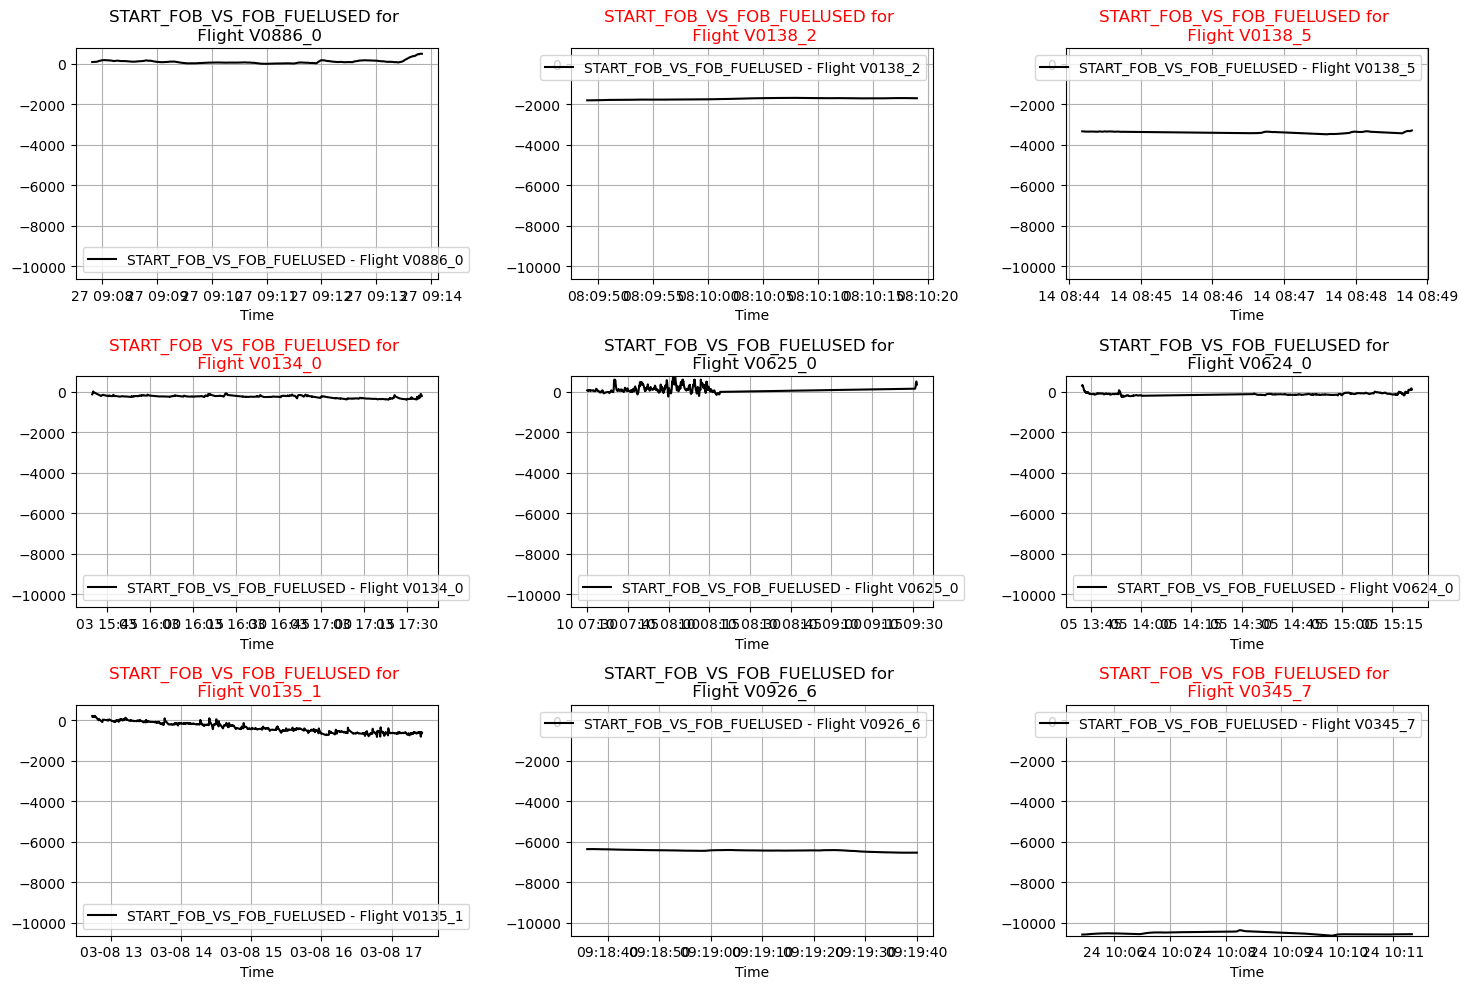

In [216]:
# Plotting START_FOB_VS_FOB_FUELUSED in Unique Fights
# =======================================
y_min = df[df['FLIGHT_ID'].isin(flights_to_plot)]['START_FOB_VS_FOB_FUELUSED'].min()
y_max = df[df['FLIGHT_ID'].isin(flights_to_plot)]['START_FOB_VS_FOB_FUELUSED'].max()

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

# Unique flights with leaks
leak_flights = set(df.loc[df['LEAK_FLOW_FLAG'] == 1, 'FLIGHT_ID'].unique())

for idx, flight in enumerate(flights_to_plot):  # skipping the first flight
    if idx >= len(axes):  # Avoid indexing error if there are more flights than subplot slots
        break
    
    flight_data = df[df['FLIGHT_ID'] == flight]
    
    ax = axes[idx]
    
    # Set title color to red if the flight has a leak, otherwise black
    title_color = 'red' if flight in leak_flights else 'black'
    
    ax.plot(flight_data.index, flight_data['START_FOB_VS_FOB_FUELUSED'], label=f'START_FOB_VS_FOB_FUELUSED - Flight {flight}', color='black')

    ax.legend()
    ax.set_title(f'START_FOB_VS_FOB_FUELUSED for \n Flight {flight}', color=title_color)
    ax.set_xlabel('Time')
    ax.set_ylim(y_min, y_max)
    ax.grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

### Altitude Difference

In [217]:
df['ALTITUDE_DIFF'].describe()

count    207967.000000
mean         -0.004969
std         164.295235
min      -24309.610000
25%          -1.120000
50%           0.020000
75%           3.375000
max       29496.124000
Name: ALTITUDE_DIFF, dtype: float64

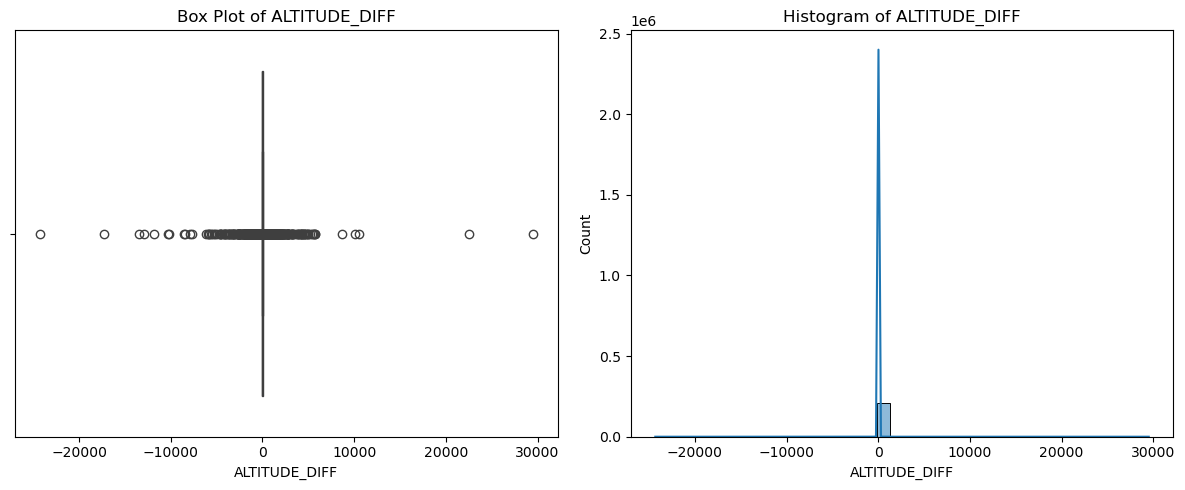

In [218]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Box plot
sns.boxplot(x=df['ALTITUDE_DIFF'], ax=axes[0])
axes[0].set_title('Box Plot of ALTITUDE_DIFF')

# Histogram
sns.histplot(df["ALTITUDE_DIFF"], bins=40, kde=True, ax=axes[1])
axes[1].set_title('Histogram of ALTITUDE_DIFF')

plt.tight_layout()
plt.show()

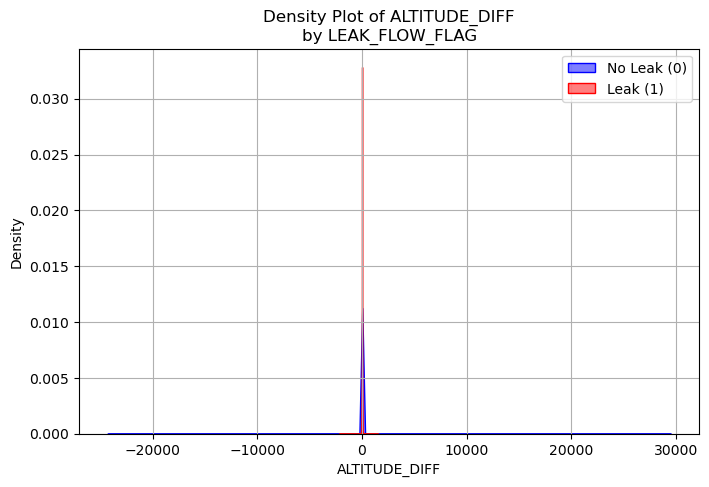

In [219]:
plt.figure(figsize=(8, 5))

sns.kdeplot(df[df['LEAK_FLOW_FLAG'] == 0]['ALTITUDE_DIFF'], 
            label="No Leak (0)", fill=True, alpha=0.5, color='blue')

sns.kdeplot(df[df['LEAK_FLOW_FLAG'] == 1]['ALTITUDE_DIFF'], 
            label="Leak (1)", fill=True, alpha=0.5, color='red')

plt.xlabel("ALTITUDE_DIFF")
plt.ylabel("Density")
plt.title("Density Plot of ALTITUDE_DIFF\nby LEAK_FLOW_FLAG")
plt.legend()
plt.grid(True)

plt.show()

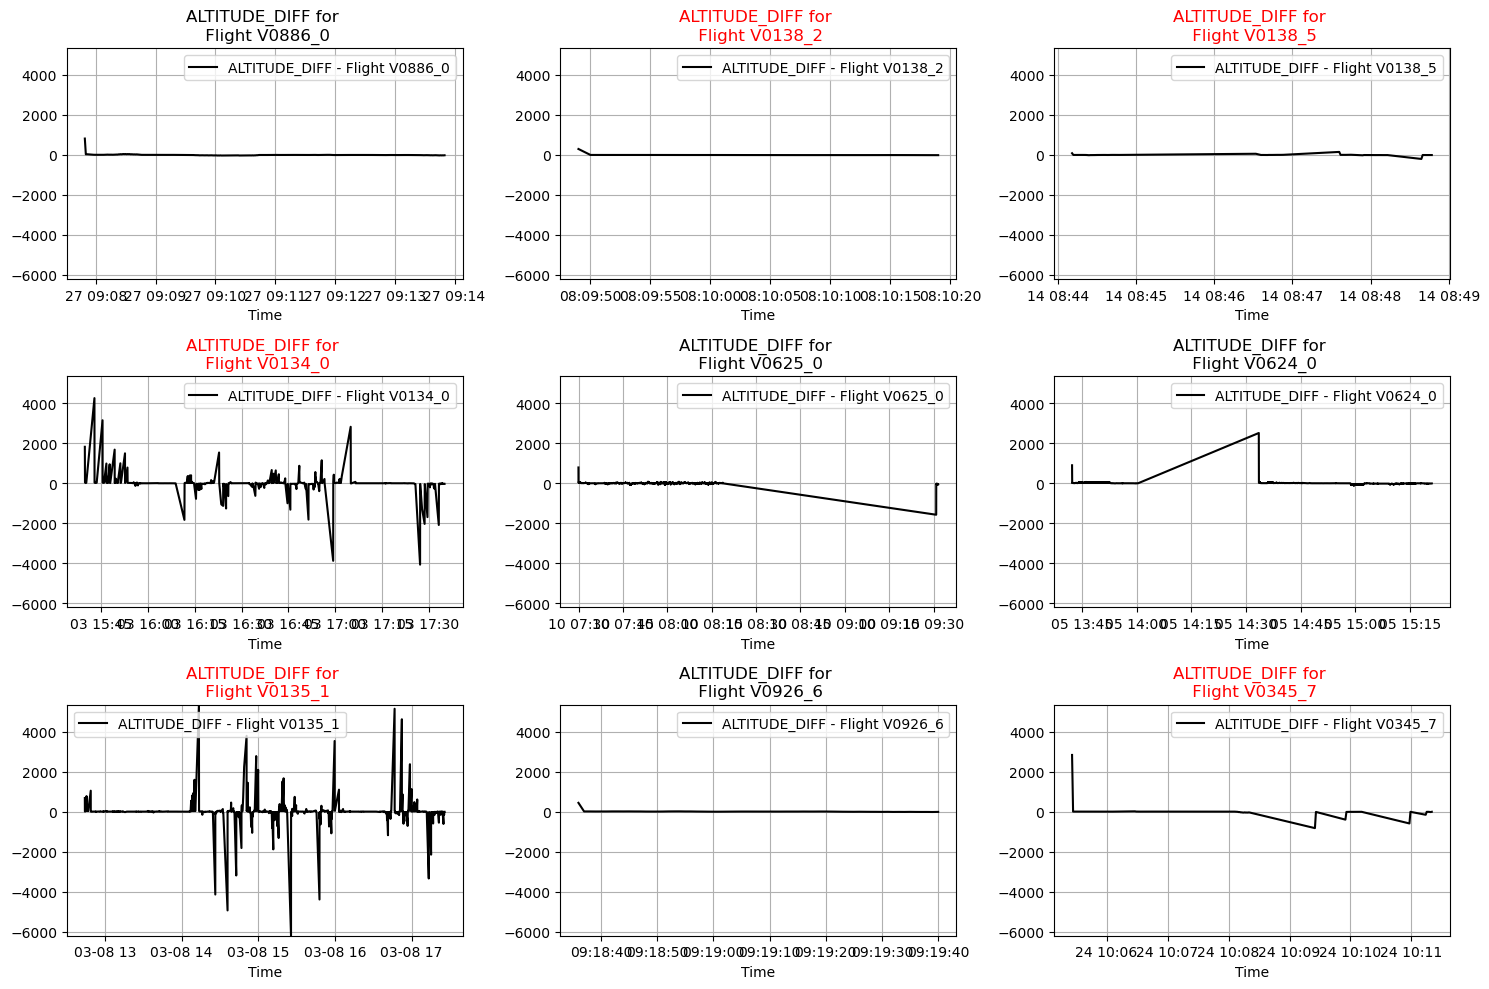

In [220]:
# Plotting ALTITUDE_DIFF in Unique Fights
# =======================================
y_min = df[df['FLIGHT_ID'].isin(flights_to_plot)]['ALTITUDE_DIFF'].min()
y_max = df[df['FLIGHT_ID'].isin(flights_to_plot)]['ALTITUDE_DIFF'].max()

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

# Unique flights with leaks
leak_flights = set(df.loc[df['LEAK_FLOW_FLAG'] == 1, 'FLIGHT_ID'].unique())

for idx, flight in enumerate(flights_to_plot):
    if idx >= len(axes):  # Avoid indexing error if there are more flights than subplot slots
        break
    
    flight_data = df[df['FLIGHT_ID'] == flight]
    
    ax = axes[idx]
    
    # Set title color to red if the flight has a leak, otherwise black
    title_color = 'red' if flight in leak_flights else 'black'
    
    ax.plot(flight_data.index, flight_data['ALTITUDE_DIFF'], label=f'ALTITUDE_DIFF - Flight {flight}', color='black')

    ax.legend()
    ax.set_title(f'ALTITUDE_DIFF for \n Flight {flight}', color=title_color)
    ax.set_xlabel('Time')
    ax.set_ylim(y_min, y_max)
    ax.grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

## Correlation Matrix

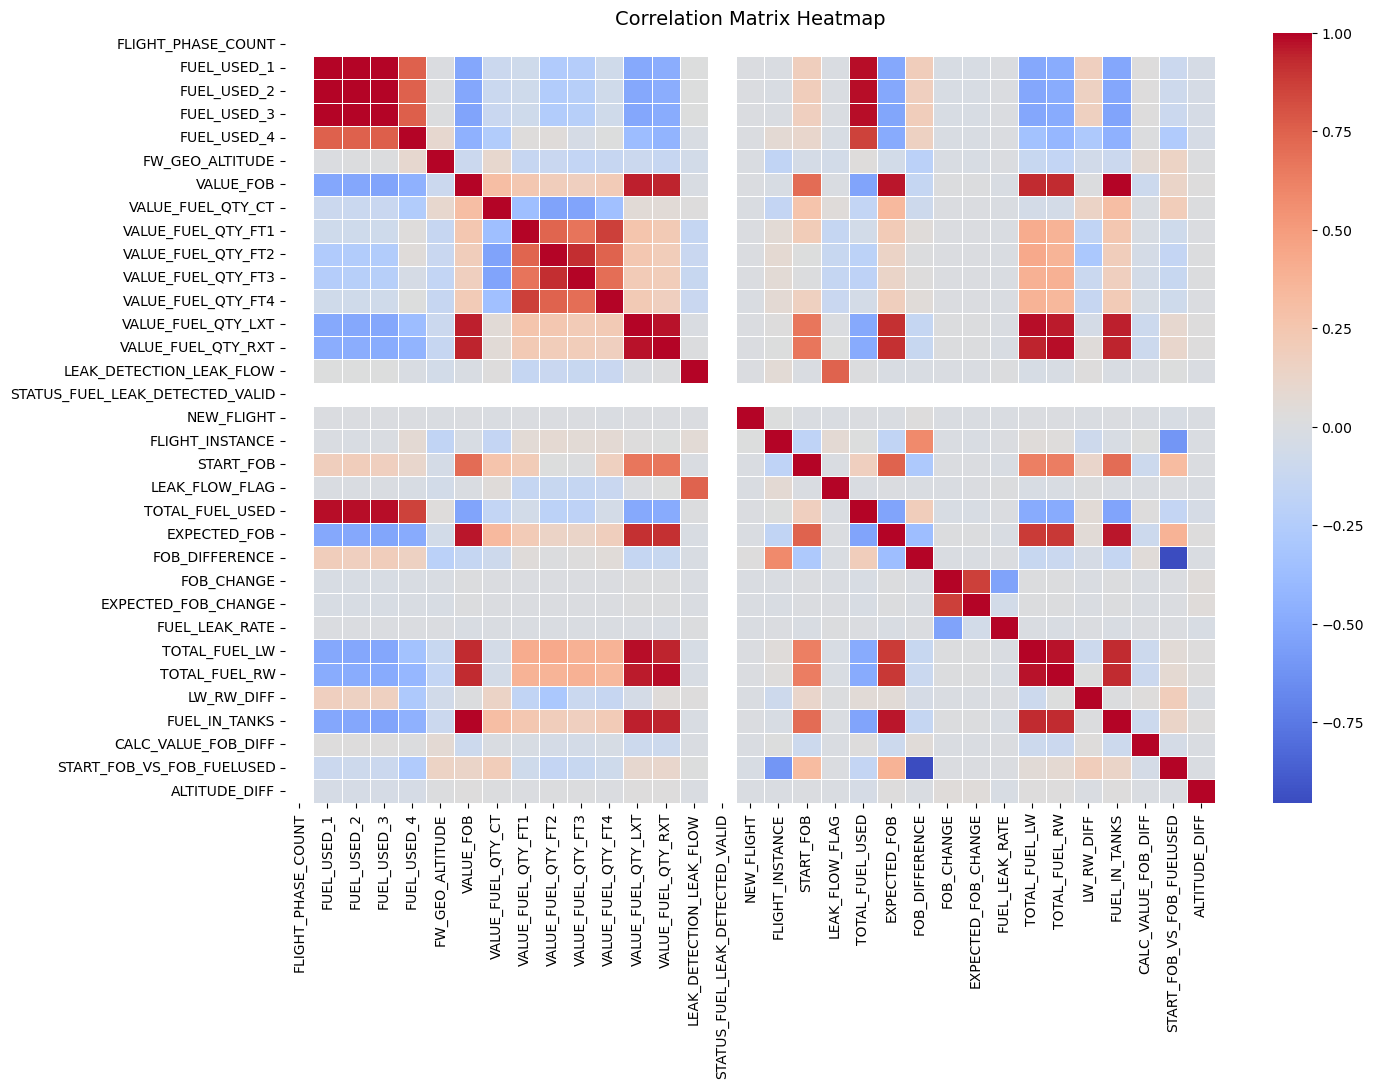

In [221]:
numeric_df = df.select_dtypes(include=['float64', 'int64', 'bool'])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)

plt.title("Correlation Matrix Heatmap", fontsize=14)
plt.show()

# PCA

In [188]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Selecting numerical features for PCA
features = df.select_dtypes(include=['float64', 'int64']).drop(columns=["LEAK_FLOW_FLAG", "LEAK_DETECTION_LEAK_FLOW"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Applying PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Feature importance for the first principal component (LEAK_FLOW_FLAG related)
feature_importance_1 = pd.DataFrame({'Feature': features.columns, 'Importance': pca.components_[0]})

# Sorting by absolute importance while keeping original values
feature_importance_1 = feature_importance_1.reindex(feature_importance_1['Importance'].abs().sort_values(ascending=False).index)

print("Feature importance for LEAK_FLOW_FLAG:")
print(feature_importance_1)

Feature importance for LEAK_FLOW_FLAG:
                            Feature    Importance
6                         VALUE_FOB  3.050780e-01
26                    FUEL_IN_TANKS  3.050769e-01
23                    TOTAL_FUEL_LW  3.044164e-01
24                    TOTAL_FUEL_RW  3.033519e-01
12               VALUE_FUEL_QTY_LXT  3.013221e-01
18                     EXPECTED_FOB  3.012573e-01
13               VALUE_FUEL_QTY_RXT  2.977031e-01
3                       FUEL_USED_3 -2.407333e-01
17                  TOTAL_FUEL_USED -2.397332e-01
1                       FUEL_USED_1 -2.379878e-01
2                       FUEL_USED_2 -2.377450e-01
4                       FUEL_USED_4 -1.974716e-01
16                        START_FOB  1.599009e-01
9                VALUE_FUEL_QTY_FT2  1.204339e-01
10               VALUE_FUEL_QTY_FT3  1.153091e-01
8                VALUE_FUEL_QTY_FT1  1.122223e-01
11               VALUE_FUEL_QTY_FT4  1.038647e-01
19                   FOB_DIFFERENCE -7.815028e-02
28        S

# Exporting to `msn02_dataset.csv`

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 207967 entries, 2010-10-26 13:32:07 to 2017-01-23 20:17:48
Data columns (total 36 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   MSN                              207967 non-null  object 
 1   Flight                           207967 non-null  object 
 2   FLIGHT_PHASE_COUNT               207967 non-null  float64
 3   FUEL_USED_1                      207967 non-null  float64
 4   FUEL_USED_2                      207967 non-null  float64
 5   FUEL_USED_3                      207967 non-null  float64
 6   FUEL_USED_4                      207967 non-null  float64
 7   FW_GEO_ALTITUDE                  207967 non-null  float64
 8   VALUE_FOB                        207967 non-null  float64
 9   VALUE_FUEL_QTY_CT                207967 non-null  float64
 10  VALUE_FUEL_QTY_FT1               207967 non-null  float64
 11  VALUE_FUEL_QTY_FT2             

In [190]:
# Save the DataFrame as a CSV
df.to_csv("msn02_prepped.csv")

In [191]:
df.head()

,MSN,Flight,FLIGHT_PHASE_COUNT,FUEL_USED_1,FUEL_USED_2,FUEL_USED_3,FUEL_USED_4,FW_GEO_ALTITUDE,VALUE_FOB,VALUE_FUEL_QTY_CT,VALUE_FUEL_QTY_FT1,VALUE_FUEL_QTY_FT2,VALUE_FUEL_QTY_FT3,VALUE_FUEL_QTY_FT4,VALUE_FUEL_QTY_LXT,VALUE_FUEL_QTY_RXT,LEAK_DETECTION_LEAK_FLOW,STATUS_FUEL_LEAK_DETECTED_VALID,NEW_FLIGHT,FLIGHT_INSTANCE,FLIGHT_ID,START_FOB,LEAK_FLOW_FLAG,TOTAL_FUEL_USED,EXPECTED_FOB,FOB_DIFFERENCE,FOB_CHANGE,EXPECTED_FOB_CHANGE,FUEL_LEAK_RATE,TOTAL_FUEL_LW,TOTAL_FUEL_RW,LW_RW_DIFF,FUEL_IN_TANKS,CALC_VALUE_FOB_DIFF,START_FOB_VS_FOB_FUELUSED,ALTITUDE_DIFF
UTC_TIME,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-10-26 13:32:07,A400M-0002,V0094,8.0,181.2604,171.6588,169.3020,165.2579,1862.500,17603.0,7563.0,1777.0,1955.0,2021.0,1729.0,1199.0,1363.0,2987.789,1.0,False,0,V0094_0,18136.0,1,687.4791,17448.5209,154.4791,0.0,0.0000,0.0000,4931.0,5113.0,182.0,17607.0,4.0,-158.4791,0.000
2010-10-26 13:32:08,A400M-0002,V0094,8.0,181.8168,172.1500,169.7946,165.8102,1902.000,17604.0,7570.0,1779.0,1952.0,2017.0,1729.0,1196.0,1363.0,2598.621,1.0,False,0,V0094_0,18136.0,1,689.5716,17446.4284,157.5716,1.0,-2.0925,-3.0925,4927.0,5109.0,182.0,17606.0,2.0,-159.5716,39.500
2010-10-26 13:32:09,A400M-0002,V0094,8.0,182.3093,172.7015,170.3493,166.3014,1942.750,17595.0,7573.0,1777.0,1948.0,2011.0,1732.0,1192.0,1366.0,2282.072,1.0,False,0,V0094_0,18136.0,0,691.6615,17444.3385,150.6615,-9.0,-2.0899,6.9101,4917.0,5109.0,192.0,17599.0,4.0,-154.6615,40.750
2010-10-26 13:32:10,A400M-0002,V0094,8.0,182.8035,173.1928,170.9017,166.7918,1982.375,17594.0,7578.0,1778.0,1948.0,2006.0,1732.0,1185.0,1370.0,2232.277,1.0,False,0,V0094_0,18136.0,0,693.6898,17442.3102,151.6898,-1.0,-2.0283,-1.0283,4911.0,5108.0,197.0,17597.0,3.0,-154.6898,39.625
2010-10-26 13:32:11,A400M-0002,V0094,8.0,183.2964,173.6837,171.3953,167.2789,2018.875,17599.0,7586.0,1778.0,1948.0,2001.0,1731.0,1180.0,1377.0,1250.586,1.0,False,0,V0094_0,18136.0,0,695.6543,17440.3457,158.6543,5.0,-1.9645,-6.9645,4906.0,5109.0,203.0,17601.0,2.0,-160.6543,36.500


# Threshold for Simulation to Other MSNs

From the EDA and from our research, the imbalance in Left Wing and Right Wing difference could potentially good indicator of a leak and is additionally available in the other MSNs, we will be using this to simulate leaks in the remainin dataset

In [204]:
df['LW_RW_DIFF'].describe()

count    207967.000000
mean        436.131353
std         785.501680
min           0.000000
25%          68.000000
50%         151.000000
75%         431.000000
max        4895.000000
Name: LW_RW_DIFF, dtype: float64

Because the third quartile of left wing and right wing fuel discrepancy is 431, we wecided to set a threshold that was slightly lower so that we are able to to detect potential significant leaks before they occur

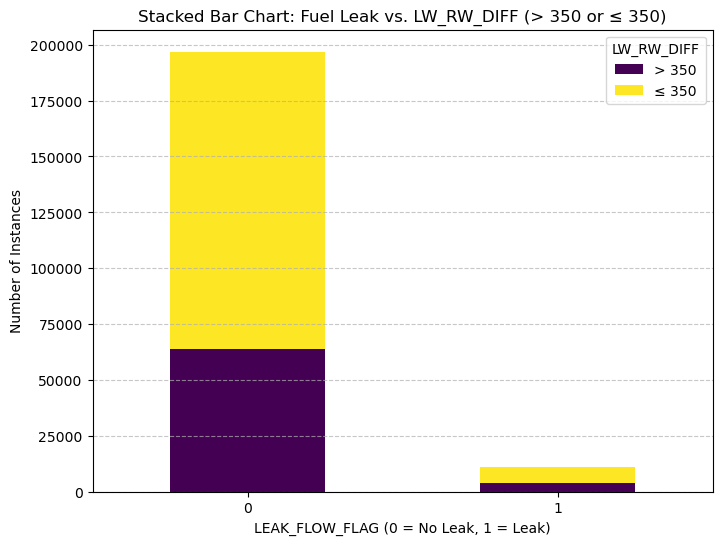

In [211]:
df['LW_RW_DIFF_Category'] = df['LW_RW_DIFF'].apply(lambda x: '> 350' if x > 350 else '≤ 350')

grouped_data = df.groupby(['LEAK_FLOW_FLAG', 'LW_RW_DIFF_Category']).size().unstack()

fig, ax = plt.subplots(figsize=(8, 6))
grouped_data.plot(kind='bar', stacked=True, colormap='viridis', ax=ax)

plt.title("Stacked Bar Chart: Fuel Leak vs. LW_RW_DIFF (> 350 or ≤ 350)")
plt.xlabel("LEAK_FLOW_FLAG (0 = No Leak, 1 = Leak)")
plt.ylabel("Number of Instances")
plt.legend(title="LW_RW_DIFF", loc="upper right")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()